In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust display width
pd.set_option('display.max_colwidth', None)  # Remove column width restriction
from prettytable import PrettyTable
from sklearn.metrics import roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")
df=pd.read_csv("/content/Modified_USAID_GHSC-PSM_Health_Commodity_Delivery_Dataset.csv")

In [3]:
# Step 2: Identify missing value percentages for each column
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Column Name': df.columns, 'Missing Percentage': missing_percentage})
missing_df_sorted = missing_df.sort_values(by='Missing Percentage', ascending=False)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print("Missing Percentage for Each Column:\n", missing_df_sorted)

Missing Percentage for Each Column:
                                                                  Column Name  \
Average Days Late Binned                            Average Days Late Binned   
RO Sent Sourcing RFX Event Date              RO Sent Sourcing RFX Event Date   
RO Clarified Date                                          RO Clarified Date   
Pick Up                                                              Pick Up   
Sourcing and Planning                                  Sourcing and Planning   
Actual Cargo Ready Date                              Actual Cargo Ready Date   
Max Departure Date                                        Max Departure Date   
Deliver                                                              Deliver   
Max Pick Up Date                                            Max Pick Up Date   
Actual Goods Available Date                      Actual Goods Available Date   
Max Arrival Date                                            Max Arrival Date   
Fis

In [4]:
# Step 3: Identify columns with more than 40% missing values
threshold = 40
columns_to_drop = missing_df_sorted[missing_df_sorted['Missing Percentage'] > threshold]['Column Name'].tolist()
print("Columns to be dropped:", columns_to_drop)

df.drop(columns=columns_to_drop, inplace=True)

print("Current columns in dataset:\n", df.columns.tolist())

Columns to be dropped: ['Average Days Late Binned', 'RO Sent Sourcing RFX Event Date', 'RO Clarified Date', 'Pick Up', 'Sourcing and Planning', 'Actual Cargo Ready Date', 'Max Departure Date']
Current columns in dataset:
 ['ROPOLine', 'Country', 'RO Number', 'Order Number', 'Status Name', 'TLP Indicator', 'Order Type', 'Fulfillment Method', 'Transportation Mode', 'Item Tracer Category', 'Product Category', 'Product_Name', 'UOM', 'Base Unit', 'Base Unit Multiplier', 'Framework Contract', 'D365 Health Element', 'D365 Funding Source', 'D365 Funding Source Detail', 'Fiscal_Year_Funding', 'Estimated Lead Time in Days', 'Vendor Incoterm', 'Destination Incoterm', 'Illustrative Price', 'Ordered Quantity', 'Shipped Quantity', 'In Full (IFD)', 'On Time (OTD)', 'Between -14 and 14', 'Between -30 and 30', 'OTIF Categories', 'OTIF Between -14 and 14', 'OTIF Between -30 and 30', 'Average Days Late', 'Delivery Progress', 'Line Delivery Status', 'Agreed Delivery Date', 'Agreed Delivery Date Year', 'Re

In [5]:
df.shape

(43396, 64)

In [6]:
# Drop 'Actual Goods Available Date' explicitly
if 'Actual Goods Available Date' in df.columns:
    df.drop(columns=['Actual Goods Available Date'], inplace=True)

# Drop 'Order Entry Date' explicitly
if 'Order Entry Date' in df.columns:
    df.drop(columns=['Order Entry Date'], inplace=True)

# Drop 'Order Entry Date' explicitly
if 'Latest Actual Delivery Date' in df.columns:
    df.drop(columns=['Latest Actual Delivery Date'], inplace=True)


In [7]:
# Replace missing values in 'Framework Contract' column with median
if 'Framework Contract' in df.columns:
    df['Framework Contract'].fillna(df['Framework Contract'].mode(), inplace=True)

if 'D365 Health Element' in df.columns:
    df['D365 Health Element'].fillna(df['D365 Health Element'].mode(), inplace=True)

if 'D365 Funding Source' in df.columns:
    df['D365 Funding Source'].fillna(df['D365 Funding Source'].mode(), inplace=True)

if 'D365 Funding Source Detail' in df.columns:
    df['D365 Funding Source Detail'].fillna(df['D365 Funding Source Detail'].mode(), inplace=True)

if 'D365 Funding Source Detail' in df.columns:
    df['D365 Funding Source Detail'].fillna(df['D365 Funding Source Detail'].mode(), inplace=True)

# Replace missing values in 'Framework Contract' column with mode (most frequent value)
if 'Framework Contract' in df.columns:
    df['Framework Contract'].fillna(df['Framework Contract'].mode()[0], inplace=True)







# Handling missing values for categorical columns
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)  # Fill with most frequent value


if 'Vendor Incoterm' in df.columns:
    df['Vendor Incoterm'].fillna(df['Vendor Incoterm'].mode(), inplace=True)

if 'Destination Incoterm' in df.columns:
    df['Destination Incoterm'].fillna(df['Destination Incoterm'].mode(), inplace=True)

if 'Illustrative Price' in df.columns:
    df['Illustrative Price'].fillna(df['Illustrative Price'].mean(), inplace=True)




# Handle numerical columns with missing values
numerical_columns = [
    "On Time (OTD)", "Between -14 and 14", "Between -30 and 30",
    "OTIF Between -14 and 14", "OTIF Between -30 and 30", "Average Days Late",
    "Requested Delivery Date Year", "Estimated Delivery Date Year"
]

for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric
    if df[col].isnull().sum() == len(df):  # If all values are NaN
        df[col].fillna(0, inplace=True)  # Default to 0 (or another reasonable value)
    else:
        df[col].fillna(df[col].median(), inplace=True)  # Fill with median

date_columns = [
    "Agreed Delivery Date", "Revised Agreed Delivery Date", "Estimated Delivery Date",
    "PO Released For Fulfillment Date",
    "Committed Goods Available Date", "Max Pick Up Date", "Max Ship Date", "Max Arrival Date"
]

# Ensure columns exist
date_columns = [col for col in date_columns if col in df.columns]

# Convert to datetime
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Fill missing values with mode
for col in date_columns:
    mode_value = df[col].dropna().mode()
    if not mode_value.empty:
        df[col].fillna(mode_value[0], inplace=True)





for col in ["Process PO/DO", "Manufacture", "Deliver"]:
    mode_value = df[col].dropna().mode()  # Get the most frequent value
    if not mode_value.empty:
        df[col].fillna(mode_value[0], inplace=True)



#Imputing Date Values
# Convert all date columns to datetime format while keeping errors as NaT
date_columns = [
    "Agreed Delivery Date", "Revised Agreed Delivery Date", "Estimated Delivery Date",
    "PO Released For Fulfillment Date", "Committed Goods Available Date",
    "Max Pick Up Date", "Max Ship Date", "Max Arrival Date"
]

# Ensure the columns exist in the dataframe
date_columns = [col for col in date_columns if col in df.columns]

# Convert date columns to datetime (handling errors)
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Replace NaT (missing dates) with a default value (e.g., "0000-00-00" or "1970-01-01")
for col in date_columns:
    df[col].fillna(pd.Timestamp("2025-02-07"), inplace=True)  # Replace NaT with a default date

# Step 1: Check and compute the mode
mode_year_series = df['Revised Agreed Delivery Date Year'].mode()

# Step 2: Fill NaNs only if mode is available
if not mode_year_series.empty:
    mode_year = mode_year_series[0]  # Get the most frequent year
    df['Revised Agreed Delivery Date Year'] = df['Revised Agreed Delivery Date Year'].fillna(mode_year)
else:
    print("No mode found — column may be completely empty.")


# Verify missing values after handling
print("Missing Values After Handling:\n", df.isnull().sum())

Missing Values After Handling:
 ROPOLine                                   0
Country                                    0
RO Number                                  0
Order Number                               0
Status Name                                0
TLP Indicator                              0
Order Type                                 0
Fulfillment Method                         0
Transportation Mode                        0
Item Tracer Category                       0
Product Category                           0
Product_Name                               0
UOM                                        0
Base Unit                                  0
Base Unit Multiplier                       0
Framework Contract                         0
D365 Health Element                        0
D365 Funding Source                        0
D365 Funding Source Detail                 0
Fiscal_Year_Funding                        0
Estimated Lead Time in Days                0
Vendor Incoterm        

In [8]:
df.drop(columns=["PO Released For Fulfillment Date Year"], inplace=True)


In [9]:
from tabulate import tabulate
# Dataset information
print("Dataset Information:")
data_info = [[col, dtype, df[col].notnull().sum()] for col, dtype in zip(df.columns, df.dtypes)]
print(tabulate(data_info, headers=["Column Name", "Data Type", "Non-Null Count"], tablefmt="fancy_grid"))


Dataset Information:
╒════════════════════════════════════╤════════════════╤══════════════════╕
│ Column Name                        │ Data Type      │   Non-Null Count │
╞════════════════════════════════════╪════════════════╪══════════════════╡
│ ROPOLine                           │ object         │            43396 │
├────────────────────────────────────┼────────────────┼──────────────────┤
│ Country                            │ object         │            43396 │
├────────────────────────────────────┼────────────────┼──────────────────┤
│ RO Number                          │ object         │            43396 │
├────────────────────────────────────┼────────────────┼──────────────────┤
│ Order Number                       │ object         │            43396 │
├────────────────────────────────────┼────────────────┼──────────────────┤
│ Status Name                        │ object         │            43396 │
├────────────────────────────────────┼────────────────┼──────────────────┤
│ TL

In [10]:
#all columns which have years as their values i have converted them into object
columns_to_convert = ["On Time (OTD)", "Between -14 and 14", "Between -30 and 30", "Revised Agreed Delivery Date Year","Order Entry Year","Requested Delivery Date Year", "Estimated Delivery Date Year", "Latest Actual Delivery Date Year"]

# Convert float to object (string)
df[columns_to_convert] = df[columns_to_convert].astype(str)

print(df[columns_to_convert].dtypes)

#convert date columns to date time format
date_columns = ["Initial PSM Source Approval Date", "Recipient Approval Date", "USAID Approval Date"]

# Convert to datetime format
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format="%A, %B %d, %Y", errors='coerce')

print(df[date_columns].dtypes)  # Should print 'datetime64[ns]' for each column
print(df[date_columns].head())  # Check the first few values



On Time (OTD)                        object
Between -14 and 14                   object
Between -30 and 30                   object
Revised Agreed Delivery Date Year    object
Order Entry Year                     object
Requested Delivery Date Year         object
Estimated Delivery Date Year         object
Latest Actual Delivery Date Year     object
dtype: object
Initial PSM Source Approval Date    datetime64[ns]
Recipient Approval Date             datetime64[ns]
USAID Approval Date                 datetime64[ns]
dtype: object
  Initial PSM Source Approval Date Recipient Approval Date USAID Approval Date
0                       2017-08-31              2017-08-31          2017-08-31
1                       2018-04-13              2018-04-13          2018-04-16
2                       2017-02-14              2017-02-22          2017-03-07
3                       2018-08-23              2018-08-23          2018-08-23
4                       2017-08-28              2017-08-29          2017

In [11]:
# Combine all date columns into one list (remove duplicates)
date_columns = list(set([
    "Agreed Delivery Date", "Revised Agreed Delivery Date", "Estimated Delivery Date",
    "PO Released For Fulfillment Date",
    "Initial PSM Source Approval Date", "Recipient Approval Date", "USAID Approval Date",
    "Committed Goods Available Date", "Max Pick Up Date", "Max Ship Date", "Max Arrival Date"
]))

# Convert to datetime and extract monthly period
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[col + "_Month"] = df[col].dt.to_period("M")
print(df[[
    "Agreed Delivery Date", "Agreed Delivery Date_Month",
    "Initial PSM Source Approval Date", "Initial PSM Source Approval Date_Month",
    "Max Pick Up Date", "Max Pick Up Date_Month"
]].head(5))


  Agreed Delivery Date Agreed Delivery Date_Month  \
0           2025-02-07                    2025-02   
1           2025-02-07                    2025-02   
2           2025-02-07                    2025-02   
3           2025-02-07                    2025-02   
4           2025-02-07                    2025-02   

  Initial PSM Source Approval Date Initial PSM Source Approval Date_Month  \
0                       2017-08-31                                2017-08   
1                       2018-04-13                                2018-04   
2                       2017-02-14                                2017-02   
3                       2018-08-23                                2018-08   
4                       2017-08-28                                2017-08   

  Max Pick Up Date Max Pick Up Date_Month  
0       2019-03-06                2019-03  
1       2019-03-06                2019-03  
2       2019-03-06                2019-03  
3       2019-03-06                2019-03 

In [12]:
# List of specific columns you want to use
selected_columns = [
    'Country',
    'Product_Name',
    'Product Category',
    'Order Type',
    'Fulfillment Method',
    'UOM',
    'Base Unit',
    'Item Tracer Category',
    'Transportation Mode',
    'Base Unit Multiplier',
    'D365 Health Element',
    'D365 Funding Source',
    'D365 Funding Source Detail',
    'Estimated Lead Time in Days',
    'Illustrative Price',
    'Ordered Quantity',
    'Shipped Quantity',
    'Average Days Late',
    "Agreed Delivery Date_Month",
    'Revised Agreed Delivery Date Year',
    'Revised Agreed Delivery Date_Month',
    'Estimated Delivery Date Year',
    'Estimated Delivery Date_Month',
    'Latest Actual Delivery Date Year',
    'Latest Actual Delivery Full Date',
    'Max Arrival Date',
    'Order Entry Full Date',
    'Order Entry Year',
    'Manufacture',
    'Deliver',

]

# Create a new dataframe with selected columns
df_selected = df[selected_columns]
df_selected.head()

,Country,Product_Name,Product Category,Order Type,Fulfillment Method,UOM,Base Unit,Item Tracer Category,Transportation Mode,Base Unit Multiplier,D365 Health Element,D365 Funding Source,D365 Funding Source Detail,Estimated Lead Time in Days,Illustrative Price,Ordered Quantity,Shipped Quantity,Average Days Late,Agreed Delivery Date_Month,Revised Agreed Delivery Date Year,Revised Agreed Delivery Date_Month,Estimated Delivery Date Year,Estimated Delivery Date_Month,Latest Actual Delivery Date Year,Latest Actual Delivery Full Date,Max Arrival Date,Order Entry Full Date,Order Entry Year,Manufacture,Deliver
0,Haiti,"Sysmex Stromatolyser-WH, 500 mL, 3 Each",Laboratory Reagents,Purchase Order,Direct Drop,PKG,Each,Laboratory,Land,3.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,162,348.01,540,540,5.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017,22/02/2025,2017-02-21,17/11/2025,2016,0.0,7.0
1,Zambia,"Sysmex Stromatolyser-WH, 500 mL, 3 Each",Laboratory Reagents,Purchase Order,Direct Drop,PKG,Each,Laboratory,Land,3.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,91,348.01,191,191,1.0,2025-02,2018.0,2025-02,2018.0,2025-02,2018,17/07/2025,2017-02-21,15/11/2025,2017,0.0,7.0
2,Mozambique,"Sysmex Stromatolyser-WH, 500 mL, 3 Each",Laboratory Reagents,Purchase Order,Direct Drop,PKG,Each,Laboratory,Land,3.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,162,348.01,730,730,0.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017,06/06/2025,2017-02-21,30/01/2025,2017,0.0,7.0
3,Zambia,"ABX Minotrol 16 Twin-Pack, High, 2 x 2.5 mL, 1 Pack",Laboratory Reagents,Purchase Order,Direct Drop,PKG,Pack,Laboratory,Land,1.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,140,137.00,210,210,4.0,2025-02,2019.0,2025-02,2019.0,2025-02,2019,20/12/2025,2017-02-21,07/08/2025,2018,0.0,7.0
4,Mozambique,"m2000 Halogen Lamp, Replacement [09K33-01], 1 Each",Laboratory Equipment,Purchase Order,Direct Drop,UNT,Each,Laboratory,Land,1.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,162,150.00,48,48,-7.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017,23/11/2025,2017-02-21,09/08/2025,2017,0.0,7.0


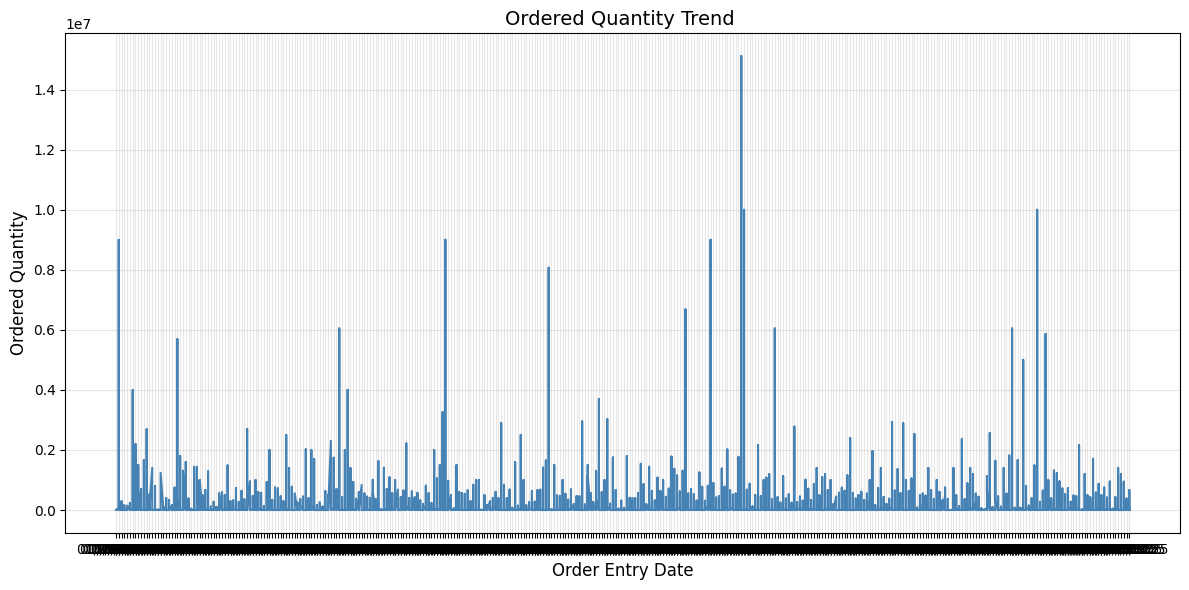

In [13]:
# --- Sort by date ---
df_selected = df_selected.sort_values('Order Entry Full Date')

# --- Plot Ordered Quantity over time ---
plt.figure(figsize=(12, 6))
plt.plot(df_selected['Order Entry Full Date'], df_selected['Ordered Quantity'], color='steelblue', linewidth=1.5)

# --- Labels and title ---
plt.title('Ordered Quantity Trend ', fontsize=14)
plt.xlabel('Order Entry Date', fontsize=12)
plt.ylabel('Ordered Quantity', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


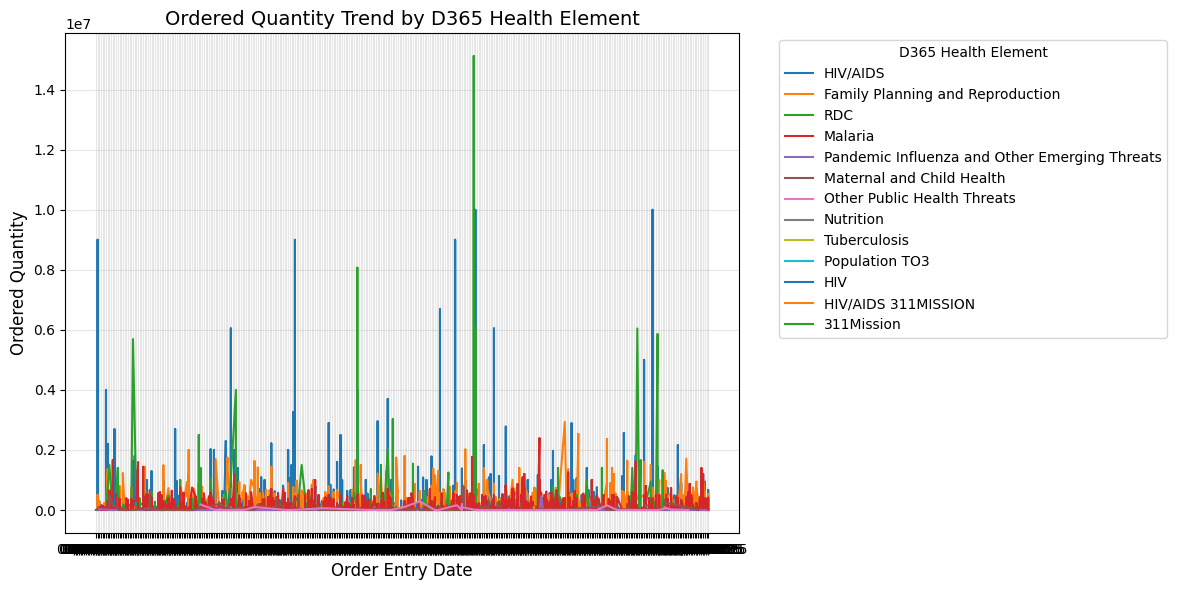

In [14]:
# --- Get unique Health Elements ---
health_elements = df_selected['D365 Health Element'].unique()

# --- Plot ---
plt.figure(figsize=(12, 6))

for element in health_elements:
    subset = df_selected[df_selected['D365 Health Element'] == element]
    plt.plot(subset['Order Entry Full Date'], subset['Ordered Quantity'], linewidth=1.5, label=element)

# --- Labels and formatting ---
plt.title('Ordered Quantity Trend by D365 Health Element', fontsize=14)
plt.xlabel('Order Entry Date', fontsize=12)
plt.ylabel('Ordered Quantity', fontsize=12)
plt.legend(title='D365 Health Element', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

**Label Encoding:**

Label Encoding means assigning a unique number to each category in a column, without caring about any order.
It just gives a number to each label, based on alphabetical order or the order it sees them.

When to Use:
Categorical features with no real order	like Color, Product ID, City

**Ordinal Encoding:**

It is a method where we assign integers to categories that have a meaningful order.
Each unique category is mapped to an integer value based on its rank/order.

Categorical features with natural ordering	Like Education Level, Risk Level, Satisfaction


In [15]:
# Unique values in categorical columns
categorical_cols = df_selected.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    print(f"\nUnique values in {col}: {df[col].nunique()}")


Unique values in Country: 96

Unique values in Product_Name: 4730

Unique values in Product Category: 34

Unique values in Order Type: 3

Unique values in Fulfillment Method: 2

Unique values in UOM: 16

Unique values in Base Unit: 58

Unique values in Item Tracer Category: 28

Unique values in Transportation Mode: 4

Unique values in D365 Health Element: 13

Unique values in D365 Funding Source: 10

Unique values in D365 Funding Source Detail: 56

Unique values in Revised Agreed Delivery Date Year: 12

Unique values in Estimated Delivery Date Year: 11

Unique values in Latest Actual Delivery Date Year: 9

Unique values in Latest Actual Delivery Full Date: 365

Unique values in Order Entry Full Date: 364

Unique values in Order Entry Year: 9


In [16]:
# Check data types of each column
print(df_selected.dtypes)


Country                                       object
Product_Name                                  object
Product Category                              object
Order Type                                    object
Fulfillment Method                            object
UOM                                           object
Base Unit                                     object
Item Tracer Category                          object
Transportation Mode                           object
Base Unit Multiplier                         float64
D365 Health Element                           object
D365 Funding Source                           object
D365 Funding Source Detail                    object
Estimated Lead Time in Days                    int64
Illustrative Price                           float64
Ordered Quantity                               int64
Shipped Quantity                               int64
Average Days Late                            float64
Agreed Delivery Date_Month                 per

In [17]:
df_selected['Order Entry Full Date'] = pd.to_datetime(df_selected['Order Entry Full Date'], format='%d/%m/%Y', errors='coerce')
df_selected['Latest Actual Delivery Full Date'] = pd.to_datetime(df_selected['Latest Actual Delivery Full Date'], format='%d/%m/%Y', errors='coerce')
print(df_selected['Order Entry Full Date'].dtypes)
print(df_selected['Order Entry Full Date'].head(10))


datetime64[ns]
2975   2025-01-01
2944   2025-01-01
2324   2025-01-01
2512   2025-01-01
719    2025-01-01
2708   2025-01-01
517    2025-01-01
2325   2025-01-01
2447   2025-01-01
2663   2025-01-01
Name: Order Entry Full Date, dtype: datetime64[ns]


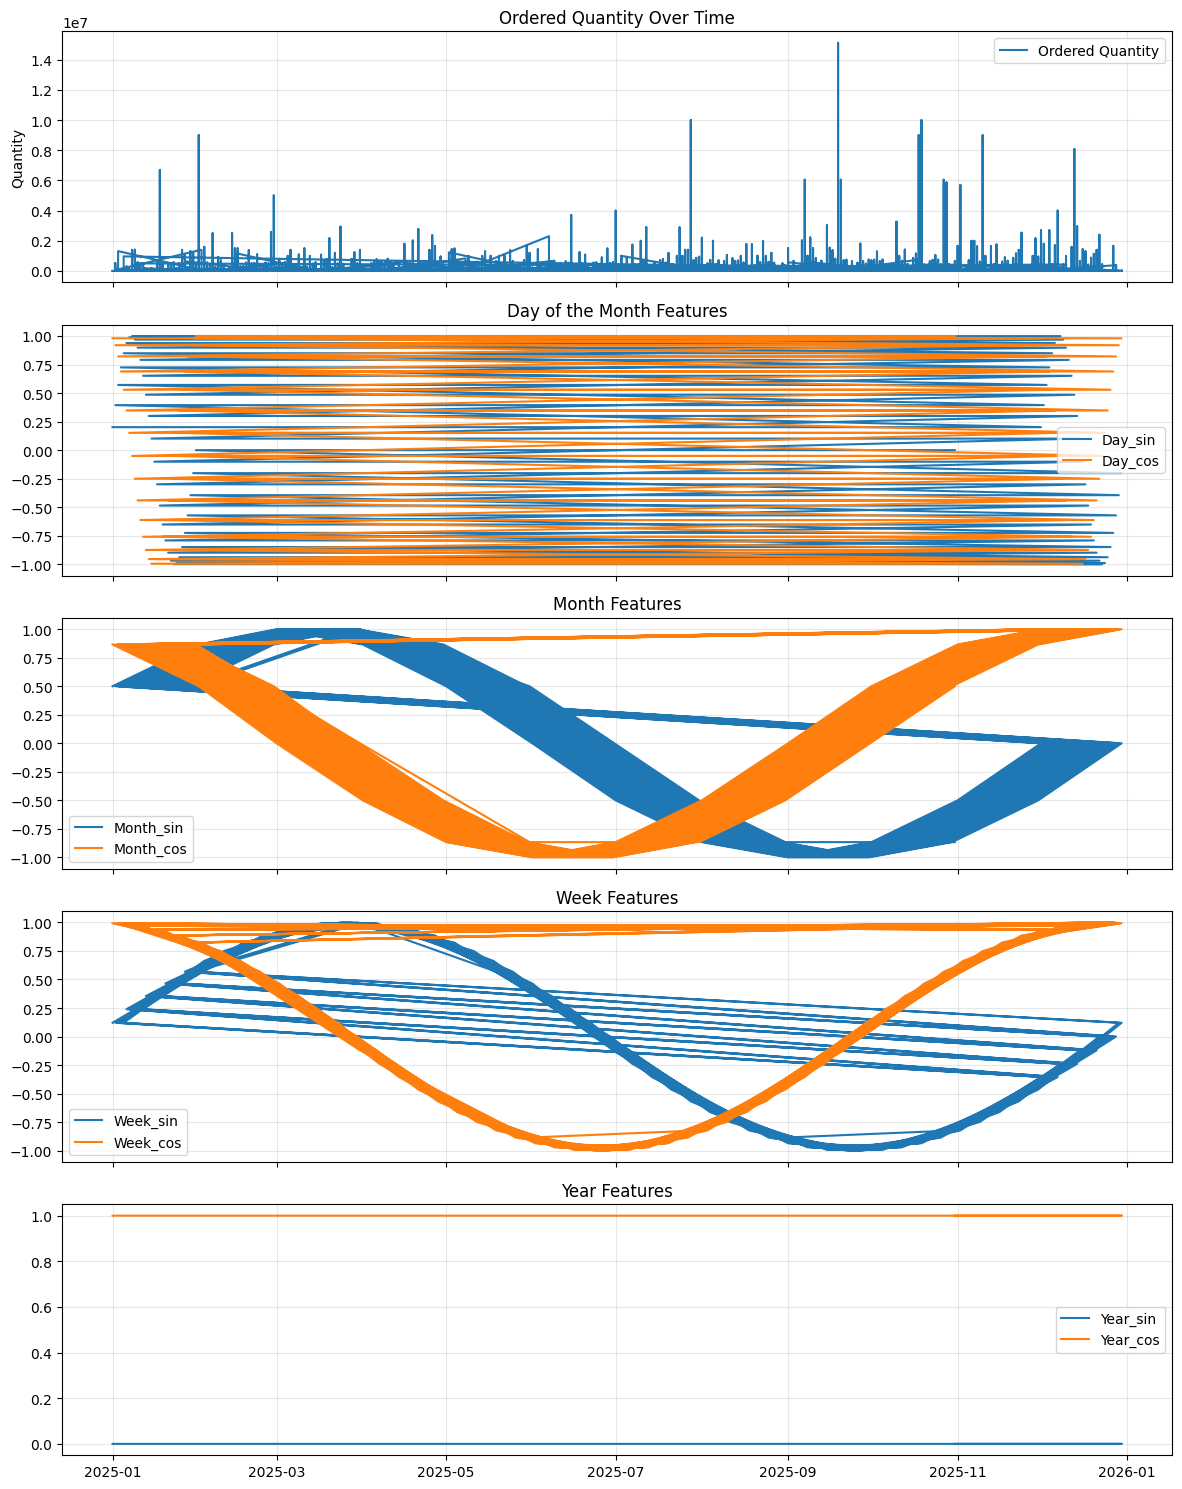

In [18]:
# Create time features
df_selected['day'] = df_selected['Order Entry Full Date'].dt.day
df_selected['month'] = df_selected['Order Entry Full Date'].dt.month
df_selected['week'] = df_selected['Order Entry Full Date'].dt.isocalendar().week.astype(int)
df_selected['year'] = df_selected['Order Entry Full Date'].dt.year

# Create cyclical encodings
df_selected['day_sin'] = np.sin(2 * np.pi * df_selected['day']/31)
df_selected['day_cos'] = np.cos(2 * np.pi * df_selected['day']/31)
df_selected['month_sin'] = np.sin(2 * np.pi * df_selected['month']/12)
df_selected['month_cos'] = np.cos(2 * np.pi * df_selected['month']/12)
df_selected['week_sin'] = np.sin(2 * np.pi * df_selected['week']/52)
df_selected['week_cos'] = np.cos(2 * np.pi * df_selected['week']/52)
df_selected['year_sin'] = np.sin(2 * np.pi * (df_selected['year'] - df_selected['year'].min()) / (df_selected['year'].max() - df_selected['year'].min() + 1))
df_selected['year_cos'] = np.cos(2 * np.pi * (df_selected['year'] - df_selected['year'].min()) / (df_selected['year'].max() - df_selected['year'].min() + 1))

# Plot
fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

axes[0].plot(df_selected['Order Entry Full Date'], df_selected['Ordered Quantity'], label='Ordered Quantity')
axes[0].set_title("Ordered Quantity Over Time")
axes[0].set_ylabel("Quantity")

axes[1].plot(df_selected['Order Entry Full Date'], df_selected['day_sin'], label='Day_sin')
axes[1].plot(df_selected['Order Entry Full Date'], df_selected['day_cos'], label='Day_cos')
axes[1].set_title("Day of the Month Features")

axes[2].plot(df_selected['Order Entry Full Date'], df_selected['month_sin'], label='Month_sin')
axes[2].plot(df_selected['Order Entry Full Date'], df_selected['month_cos'], label='Month_cos')
axes[2].set_title("Month Features")

axes[3].plot(df_selected['Order Entry Full Date'], df_selected['week_sin'], label='Week_sin')
axes[3].plot(df_selected['Order Entry Full Date'], df_selected['week_cos'], label='Week_cos')
axes[3].set_title("Week Features")

axes[4].plot(df_selected['Order Entry Full Date'], df_selected['year_sin'], label='Year_sin')
axes[4].plot(df_selected['Order Entry Full Date'], df_selected['year_cos'], label='Year_cos')
axes[4].set_title("Year Features")

for ax in axes:
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

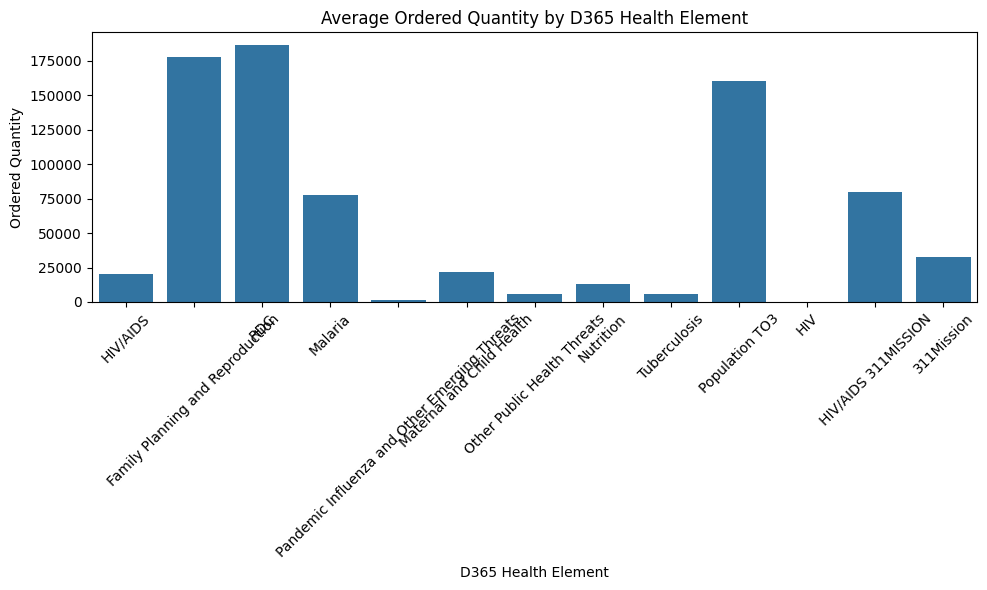

In [19]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=df_selected, x='D365 Health Element', y='Ordered Quantity', estimator='mean', ci=None)
plt.title('Average Ordered Quantity by D365 Health Element')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


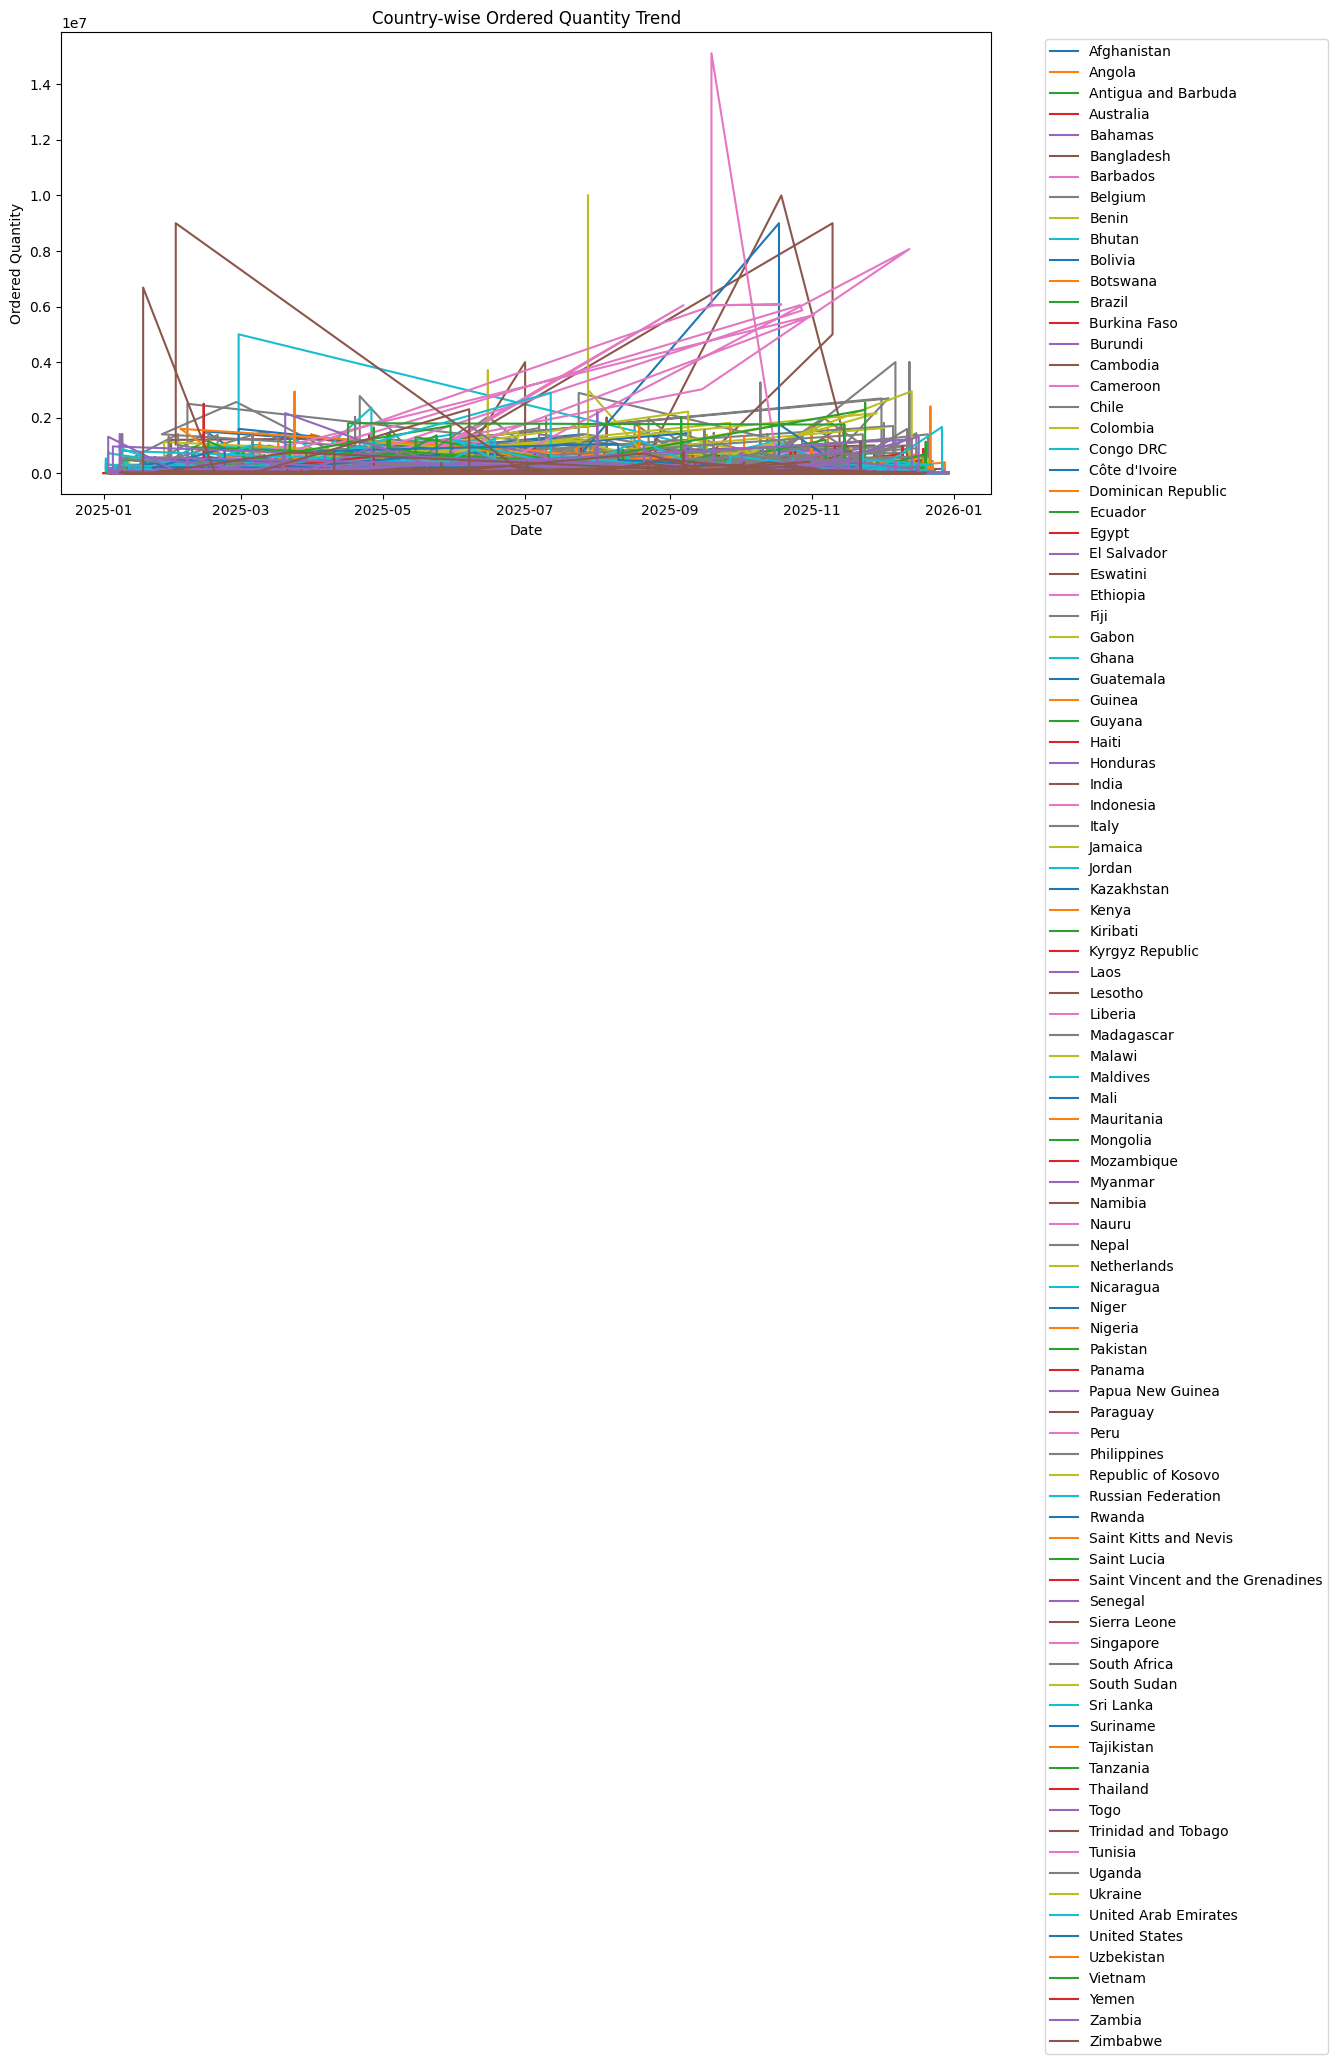

In [20]:
plt.figure(figsize=(12,6))
for country, subset in df_selected.groupby('Country'):
    plt.plot(subset['Order Entry Full Date'], subset['Ordered Quantity'], label=country)
plt.title('Country-wise Ordered Quantity Trend')
plt.xlabel('Date')
plt.ylabel('Ordered Quantity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


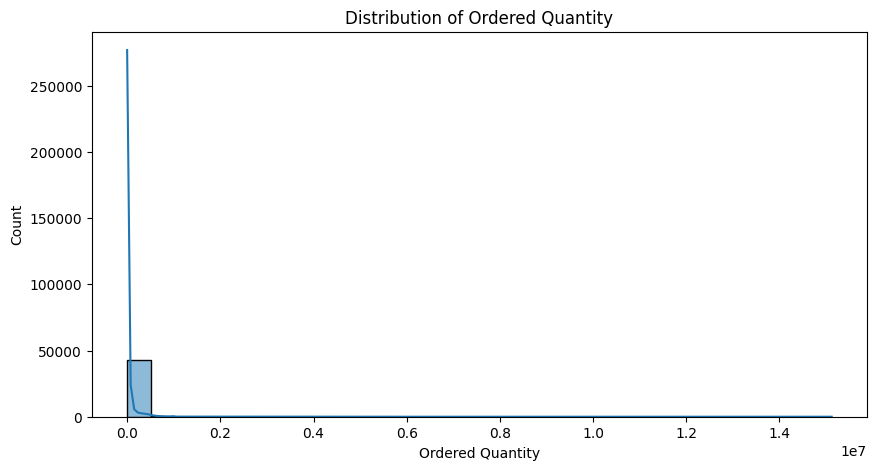

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(df_selected['Ordered Quantity'], bins=30, kde=True)
plt.title('Distribution of Ordered Quantity')
plt.show()


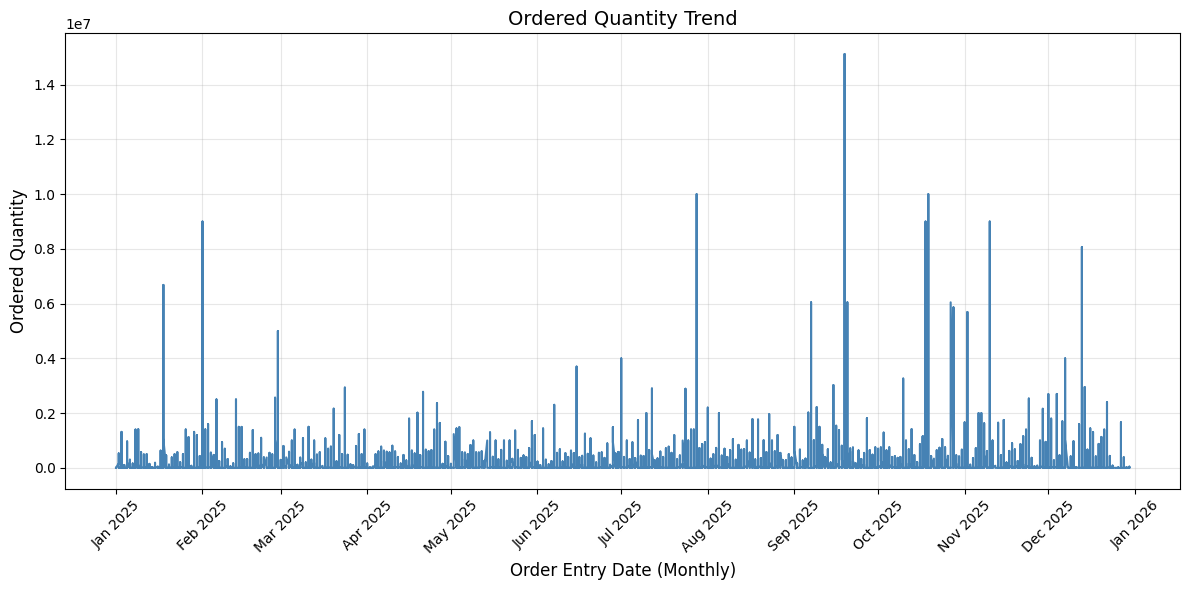

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # ✅ Add this import

# --- Sort by date ---
df_selected = df_selected.sort_values('Order Entry Full Date')

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(df_selected['Order Entry Full Date'], df_selected['Ordered Quantity'],
         color='steelblue', linewidth=1.5)

# --- Format x-axis to show months ---
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())              # major ticks = every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))    # format as "Jan 2024"

# --- Labels and title ---
plt.title('Ordered Quantity Trend', fontsize=14)
plt.xlabel('Order Entry Date (Monthly)', fontsize=12)
plt.ylabel('Ordered Quantity', fontsize=12)
plt.grid(alpha=0.3)

# Rotate month labels for readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


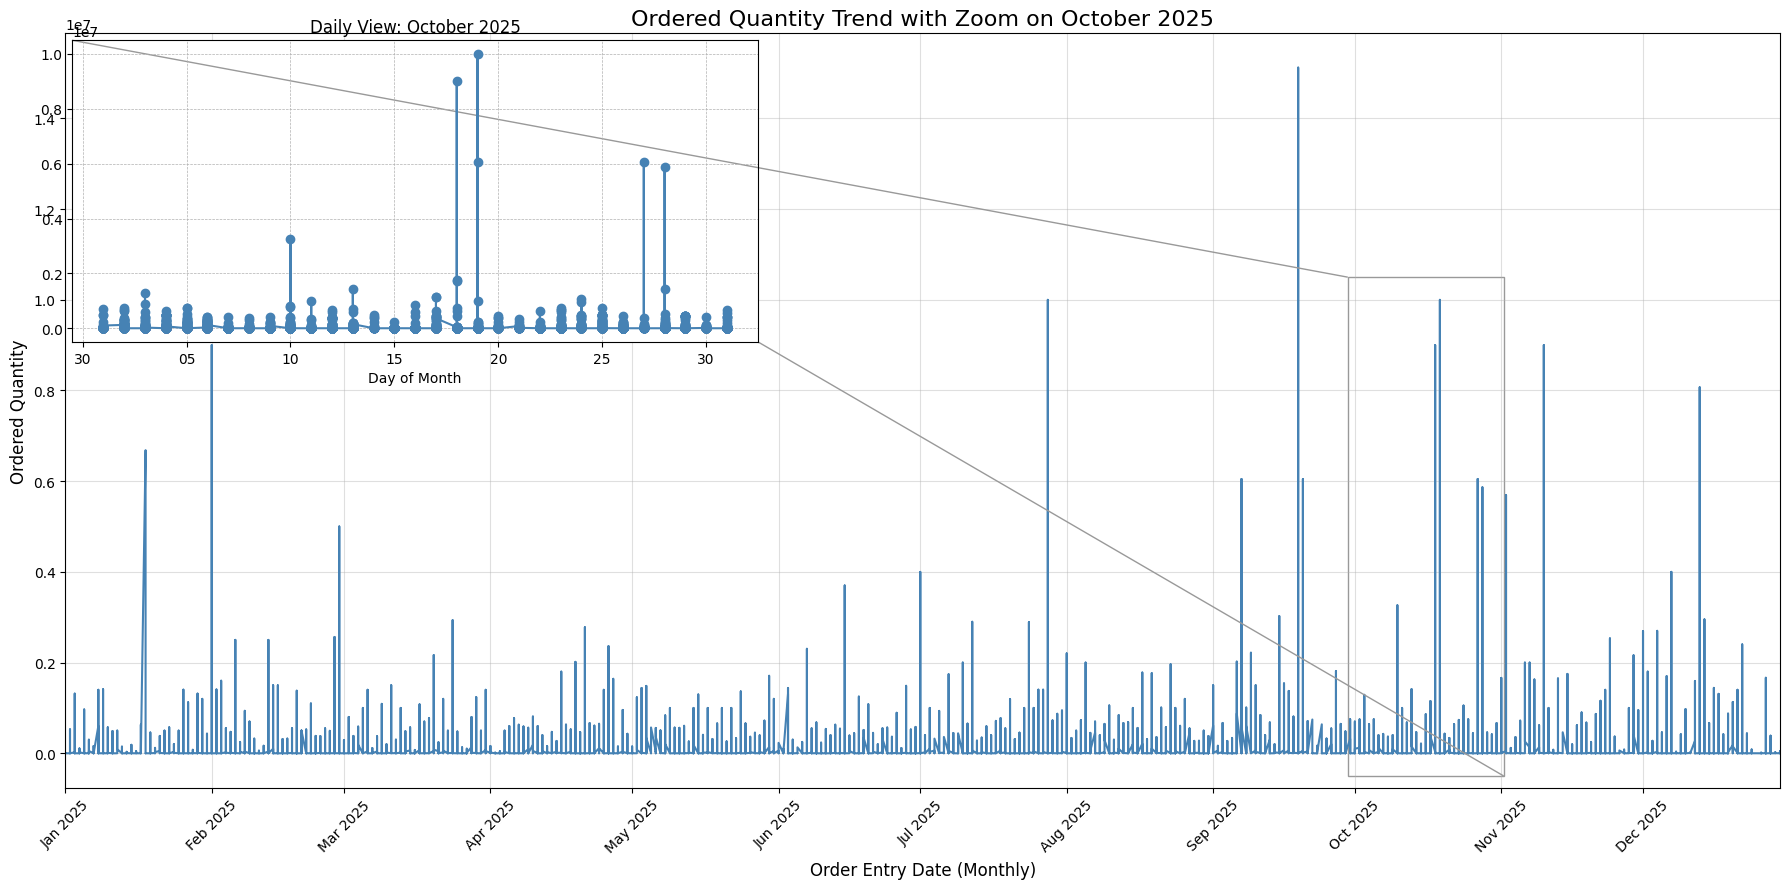

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# --- Prerequisite ---
# Ensure 'df_selected' is loaded and the date column is in datetime format.
df_selected['Order Entry Full Date'] = pd.to_datetime(df_selected['Order Entry Full Date'])
df_selected = df_selected.sort_values('Order Entry Full Date')

# 1. --- Create the Main Plot (Yearly Trend) ---
fig, ax = plt.subplots(figsize=(18, 9))
ax.plot(df_selected['Order Entry Full Date'], df_selected['Ordered Quantity'], color='steelblue', linewidth=1.5)

# --- Formatting the Main Plot ---
ax.set_title('Ordered Quantity Trend with Zoom on October 2025', fontsize=16)
ax.set_xlabel('Order Entry Date (Monthly)', fontsize=12)
ax.set_ylabel('Ordered Quantity', fontsize=12)
ax.grid(alpha=0.4)

# Format x-axis to show months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)


# 2. --- Create the Inset Plot (Zoom on October) ---
# Create a new set of axes for the inset plot, positioned in the upper left
ax_inset = inset_axes(ax, width="40%", height="40%", loc='upper left')

# Filter data for October 2025
df_october = df_selected[df_selected['Order Entry Full Date'].dt.month == 10]
ax_inset.plot(df_october['Order Entry Full Date'], df_october['Ordered Quantity'], color='steelblue', marker='o', linestyle='-')

# --- Formatting the Inset Plot ---
ax_inset.set_title('Daily View: October 2025')
ax_inset.grid(True, linestyle='--', linewidth=0.5)

# Format x-axis for the inset to show days
ax_inset.xaxis.set_major_locator(mdates.DayLocator(interval=5)) # A tick every 5 days
ax_inset.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax_inset.set_xlabel('Day of Month')


# 3. --- Draw a box and lines to connect the main plot to the inset ---
# Define the date range for the zoom box on the main plot
zoom_start = pd.to_datetime('2025-10-01')
zoom_end = pd.to_datetime('2025-10-31')
ax.set_xlim(df_selected['Order Entry Full Date'].min(), df_selected['Order Entry Full Date'].max()) # Ensure full range is shown
mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.6")

plt.tight_layout()
plt.show()

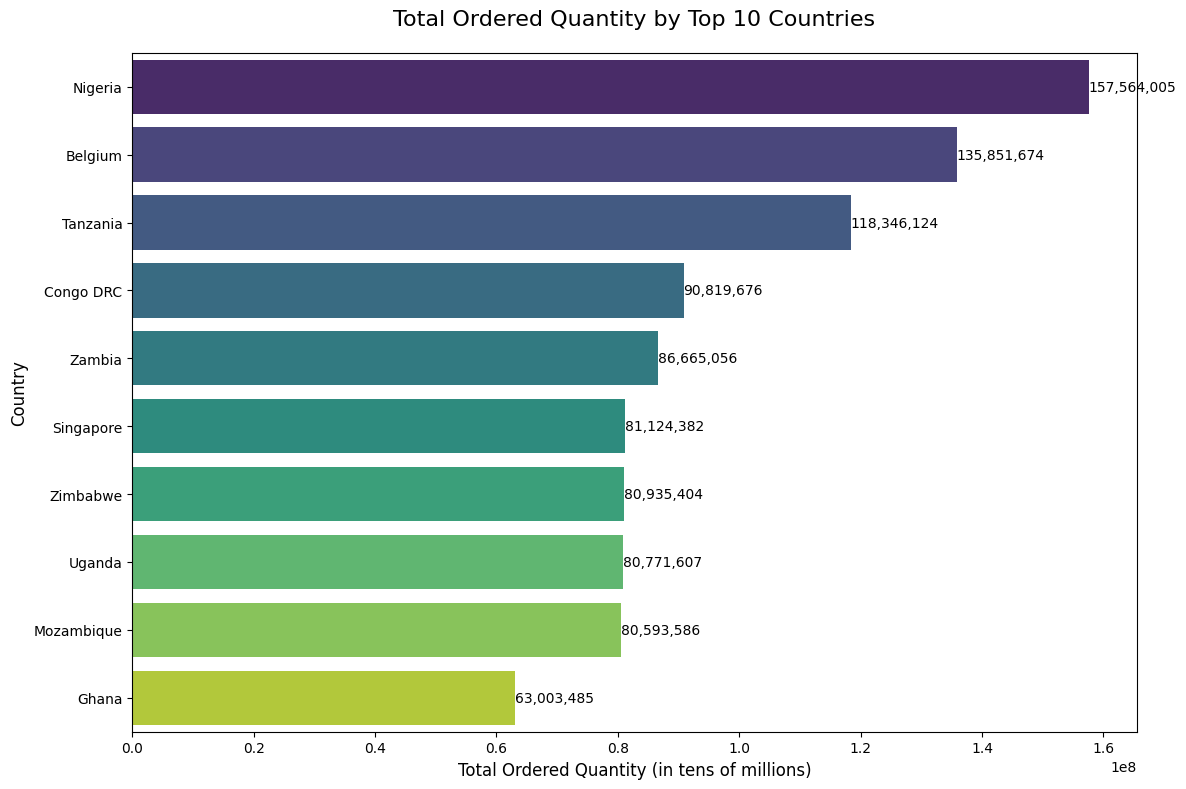

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# (Assuming 'df_selected' is your pre-loaded DataFrame)

# --- Plot 2: Bar Chart for Top 10 Countries ---

# Group by country and sum the quantities
country_demand = df_selected.groupby('Country')['Ordered Quantity'].sum().reset_index()

# Get the top 10 countries
top_10_demand = country_demand.nlargest(10, 'Ordered Quantity')

# Create the plot
plt.figure(figsize=(12, 8))

# Use a barplot for clear comparison
ax = sns.barplot(data=top_10_demand,
                 x='Ordered Quantity',
                 y='Country',
                 palette='viridis',
                 orient='h')

# --- Formatting ---
plt.title('Total Ordered Quantity by Top 10 Countries', fontsize=16, pad=20)
plt.xlabel('Total Ordered Quantity (in tens of millions)', fontsize=12)
plt.ylabel('Country', fontsize=12)

# Add value labels to the end of each bar for clarity
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.1,
             p.get_y() + p.get_height() / 2,
             f'{width:,.0f}',
             ha='left',
             va='center')

plt.tight_layout()
plt.show()

In [25]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Mention only the columns you want to encode
columns_to_encode = [
    'Country',
    'Product_Name',
    'Product Category',
    'Order Type',
    'Fulfillment Method',
    'UOM',
    'Base Unit',
    'Item Tracer Category',
    'Transportation Mode',
    'D365 Health Element',
    'D365 Funding Source',
    'D365 Funding Source Detail',


]


# Step 1: Create a dictionary to hold encoders
encoders = {}

# Step 2: Encode each column with its own encoder
for col in columns_to_encode:
    le = LabelEncoder()
    df_selected[col] = le.fit_transform(df_selected[col].astype(str))
    encoders[col] = le  # Save this encoder for decoding later


# Step 3: Verify changes
print(df_selected[columns_to_encode].dtypes)  # Should print int64 for these columns


Country                       int64
Product_Name                  int64
Product Category              int64
Order Type                    int64
Fulfillment Method            int64
UOM                           int64
Base Unit                     int64
Item Tracer Category          int64
Transportation Mode           int64
D365 Health Element           int64
D365 Funding Source           int64
D365 Funding Source Detail    int64
dtype: object


In [26]:
df_selected.head()

,Country,Product_Name,Product Category,Order Type,Fulfillment Method,UOM,Base Unit,Item Tracer Category,Transportation Mode,Base Unit Multiplier,D365 Health Element,D365 Funding Source,D365 Funding Source Detail,Estimated Lead Time in Days,Illustrative Price,Ordered Quantity,Shipped Quantity,Average Days Late,Agreed Delivery Date_Month,Revised Agreed Delivery Date Year,Revised Agreed Delivery Date_Month,Estimated Delivery Date Year,Estimated Delivery Date_Month,Latest Actual Delivery Date Year,Latest Actual Delivery Full Date,Max Arrival Date,Order Entry Full Date,Order Entry Year,Manufacture,Deliver,day,month,week,year,day_sin,day_cos,month_sin,month_cos,week_sin,week_cos,year_sin,year_cos
2975,53,4690,12,1,0,15,14,13,0,1.0,3,5,27,162,150.0,2,2,11.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017,2025-02-10,2017-02-21,2025-01-01,2017,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0
2944,53,4690,12,1,0,15,14,13,0,1.0,3,5,27,162,150.0,2,2,11.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017,2025-02-10,2017-02-21,2025-01-01,2017,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0
2324,53,4698,11,1,0,15,14,13,0,1.0,3,5,27,162,675.0,1,1,11.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017,2025-02-10,2017-02-21,2025-01-01,2017,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0
2512,53,4698,11,1,0,15,14,13,0,1.0,3,5,27,162,675.0,1,1,11.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017,2025-02-10,2017-02-21,2025-01-01,2017,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0
719,53,2093,11,1,0,10,39,13,0,20.0,3,5,27,162,30.5,1536,1536,1.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017,2025-03-02,2017-02-21,2025-01-01,2017,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0


In [27]:
df_selected.shape

(43396, 42)

In [28]:
# List of columns you want to convert
columns_to_float = [
    'Revised Agreed Delivery Date Year',
    'Estimated Delivery Date Year',
    'Latest Actual Delivery Date Year',
    'Order Entry Year'
]

# Convert them to float64
for col in columns_to_float:
    if col in df_selected.columns:
        df_selected[col] = df_selected[col].astype('float64')

# Verify
print(df_selected[columns_to_float].dtypes)


Revised Agreed Delivery Date Year    float64
Estimated Delivery Date Year         float64
Latest Actual Delivery Date Year     float64
Order Entry Year                     float64
dtype: object


In [29]:
columns_to_decode = [
    'Country',
    'Product_Name',
    'Product Category',
    'Order Type',
    'Fulfillment Method',
    'UOM',
    'Base Unit',
    'Item Tracer Category',
    'Transportation Mode',
    'D365 Health Element',
    'D365 Funding Source',
    'D365 Funding Source Detail',
]

for col in columns_to_decode:
    df_selected[col] = encoders[col].inverse_transform(df_selected[col])

df_selected.head()


,Country,Product_Name,Product Category,Order Type,Fulfillment Method,UOM,Base Unit,Item Tracer Category,Transportation Mode,Base Unit Multiplier,D365 Health Element,D365 Funding Source,D365 Funding Source Detail,Estimated Lead Time in Days,Illustrative Price,Ordered Quantity,Shipped Quantity,Average Days Late,Agreed Delivery Date_Month,Revised Agreed Delivery Date Year,Revised Agreed Delivery Date_Month,Estimated Delivery Date Year,Estimated Delivery Date_Month,Latest Actual Delivery Date Year,Latest Actual Delivery Full Date,Max Arrival Date,Order Entry Full Date,Order Entry Year,Manufacture,Deliver,day,month,week,year,day_sin,day_cos,month_sin,month_cos,week_sin,week_cos,year_sin,year_cos
2975,Mozambique,"m2000 Halogen Lamp, Replacement [09K33-01], 1 Each",Laboratory Equipment,Purchase Order,Direct Drop,UNT,Each,Laboratory,Air,1.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,162,150.0,2,2,11.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017.0,2025-02-10,2017-02-21,2025-01-01,2017.0,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0
2944,Mozambique,"m2000 Halogen Lamp, Replacement [09K33-01], 1 Each",Laboratory Equipment,Purchase Order,Direct Drop,UNT,Each,Laboratory,Air,1.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,162,150.0,2,2,11.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017.0,2025-02-10,2017-02-21,2025-01-01,2017.0,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0
2324,Mozambique,"m2000 Optical Calibration Kit [04J71-93], 1 Each",Laboratory Consumables,Purchase Order,Direct Drop,UNT,Each,Laboratory,Air,1.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,162,675.0,1,1,11.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017.0,2025-02-10,2017-02-21,2025-01-01,2017.0,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0
2512,Mozambique,"m2000 Optical Calibration Kit [04J71-93], 1 Each",Laboratory Consumables,Purchase Order,Direct Drop,UNT,Each,Laboratory,Air,1.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,162,675.0,1,1,11.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017.0,2025-02-10,2017-02-21,2025-01-01,2017.0,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0
719,Mozambique,"Dried Blood Spot Collection Kit w/ TFN or Whatman 903 Cards, Perforated, Single Use, 20 Tests",Laboratory Consumables,Purchase Order,Direct Drop,PKG,Test,Laboratory,Air,20.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,162,30.5,1536,1536,1.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017.0,2025-03-02,2017-02-21,2025-01-01,2017.0,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0


In [30]:
'''import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")


# Confirm your columns are decoded and ready
print(df_selected[['Country', 'D365 Health Element']].head())

# Group and forecast by country + health element
grouped = df_selected.groupby(['Country', 'D365 Health Element'])

for (country, element), group in grouped:
    ts = group.groupby('Order Entry Full Date')['Ordered Quantity'].sum().reset_index()
    ts.rename(columns={'Order Entry Full Date': 'ds', 'Ordered Quantity': 'y'}, inplace=True)
    ts = ts.set_index('ds').asfreq('D')
    ts['y'] = ts['y'].fillna(0)

    if ts['y'].sum() == 0 or len(ts) < 30:
        continue  # skip if insufficient data

    try:
        model = ARIMA(ts['y'], order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=30)
        fc_mean = forecast.predicted_mean
        conf_int = forecast.conf_int()

        plt.figure(figsize=(10,5))
        plt.plot(ts['y'], label='Historical')
        plt.plot(fc_mean.index, fc_mean.values, label='Forecast', color='red')
        plt.fill_between(fc_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
        plt.title(f"Forecast: {country} - {element}")
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Model failed for {country} - {element}: {e}")
'''

'import pandas as pd\nimport matplotlib.pyplot as plt\nfrom statsmodels.tsa.stattools import adfuller\nfrom statsmodels.tsa.arima.model import ARIMA\nfrom statsmodels.graphics.tsaplots import plot_acf, plot_pacf\nimport warnings\nwarnings.filterwarnings("ignore")\n\n\n# Confirm your columns are decoded and ready\nprint(df_selected[[\'Country\', \'D365 Health Element\']].head())\n\n# Group and forecast by country + health element\ngrouped = df_selected.groupby([\'Country\', \'D365 Health Element\'])\n\nfor (country, element), group in grouped:\n    ts = group.groupby(\'Order Entry Full Date\')[\'Ordered Quantity\'].sum().reset_index()\n    ts.rename(columns={\'Order Entry Full Date\': \'ds\', \'Ordered Quantity\': \'y\'}, inplace=True)\n    ts = ts.set_index(\'ds\').asfreq(\'D\')\n    ts[\'y\'] = ts[\'y\'].fillna(0)\n\n    if ts[\'y\'].sum() == 0 or len(ts) < 30:\n        continue  # skip if insufficient data\n\n    try:\n        model = ARIMA(ts[\'y\'], order=(1,1,1))\n        model_fi

In [31]:
'''import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")


# Confirm your columns are decoded and ready
print(df_selected[['Country', 'D365 Health Element']].head())

# Group and forecast by country + health element
grouped = df_selected.groupby(['Country', 'D365 Health Element'])

for (country, element), group in grouped:
    ts = group.groupby('Order Entry Full Date')['Ordered Quantity'].sum().reset_index()
    ts.rename(columns={'Order Entry Full Date': 'ds', 'Ordered Quantity': 'y'}, inplace=True)
    ts = ts.set_index('ds').asfreq('D')
    ts['y'] = ts['y'].fillna(0)

    if ts['y'].sum() == 0 or len(ts) < 30:
        continue  # skip if insufficient data

    try:
        model = ARIMA(ts['y'], order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=30)
        fc_mean = forecast.predicted_mean
        conf_int = forecast.conf_int()

        plt.figure(figsize=(10,5))
        plt.plot(ts['y'], label='Historical')
        plt.plot(fc_mean.index, fc_mean.values, label='Forecast', color='red')
        plt.fill_between(fc_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
        plt.title(f"Forecast: {country} - {element}")
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Model failed for {country} - {element}: {e}")
'''

'import pandas as pd\nimport matplotlib.pyplot as plt\nfrom statsmodels.tsa.stattools import adfuller\nfrom statsmodels.tsa.arima.model import ARIMA\nfrom statsmodels.graphics.tsaplots import plot_acf, plot_pacf\nimport warnings\nwarnings.filterwarnings("ignore")\n\n\n# Confirm your columns are decoded and ready\nprint(df_selected[[\'Country\', \'D365 Health Element\']].head())\n\n# Group and forecast by country + health element\ngrouped = df_selected.groupby([\'Country\', \'D365 Health Element\'])\n\nfor (country, element), group in grouped:\n    ts = group.groupby(\'Order Entry Full Date\')[\'Ordered Quantity\'].sum().reset_index()\n    ts.rename(columns={\'Order Entry Full Date\': \'ds\', \'Ordered Quantity\': \'y\'}, inplace=True)\n    ts = ts.set_index(\'ds\').asfreq(\'D\')\n    ts[\'y\'] = ts[\'y\'].fillna(0)\n\n    if ts[\'y\'].sum() == 0 or len(ts) < 30:\n        continue  # skip if insufficient data\n\n    try:\n        model = ARIMA(ts[\'y\'], order=(1,1,1))\n        model_fi

In [32]:
'''df_selected['Country'] = encoders['Country'].inverse_transform(df_selected['Country'])
df_selected['D365 Health Element'] = encoders['D365 Health Element'].inverse_transform(df_selected['D365 Health Element'])
'''


"df_selected['Country'] = encoders['Country'].inverse_transform(df_selected['Country'])\ndf_selected['D365 Health Element'] = encoders['D365 Health Element'].inverse_transform(df_selected['D365 Health Element'])\n"

In [33]:
'''print(df_selected[['Country', 'D365 Health Element']].head())'''


"print(df_selected[['Country', 'D365 Health Element']].head())"

In [34]:
'''df_selected['Country_Label'] = encoders['Country'].inverse_transform(df_selected['Country'])
df_selected['HealthElement_Label'] = encoders['D365 Health Element'].inverse_transform(df_selected['D365 Health Element'])
'''

"df_selected['Country_Label'] = encoders['Country'].inverse_transform(df_selected['Country'])\ndf_selected['HealthElement_Label'] = encoders['D365 Health Element'].inverse_transform(df_selected['D365 Health Element'])\n"

In [35]:
'''df_selected[['Country', 'Country_Label', 'D365 Health Element', 'HealthElement_Label']].head()
'''

"df_selected[['Country', 'Country_Label', 'D365 Health Element', 'HealthElement_Label']].head()\n"

In [36]:
df_selected.head()

,Country,Product_Name,Product Category,Order Type,Fulfillment Method,UOM,Base Unit,Item Tracer Category,Transportation Mode,Base Unit Multiplier,D365 Health Element,D365 Funding Source,D365 Funding Source Detail,Estimated Lead Time in Days,Illustrative Price,Ordered Quantity,Shipped Quantity,Average Days Late,Agreed Delivery Date_Month,Revised Agreed Delivery Date Year,Revised Agreed Delivery Date_Month,Estimated Delivery Date Year,Estimated Delivery Date_Month,Latest Actual Delivery Date Year,Latest Actual Delivery Full Date,Max Arrival Date,Order Entry Full Date,Order Entry Year,Manufacture,Deliver,day,month,week,year,day_sin,day_cos,month_sin,month_cos,week_sin,week_cos,year_sin,year_cos
2975,Mozambique,"m2000 Halogen Lamp, Replacement [09K33-01], 1 Each",Laboratory Equipment,Purchase Order,Direct Drop,UNT,Each,Laboratory,Air,1.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,162,150.0,2,2,11.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017.0,2025-02-10,2017-02-21,2025-01-01,2017.0,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0
2944,Mozambique,"m2000 Halogen Lamp, Replacement [09K33-01], 1 Each",Laboratory Equipment,Purchase Order,Direct Drop,UNT,Each,Laboratory,Air,1.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,162,150.0,2,2,11.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017.0,2025-02-10,2017-02-21,2025-01-01,2017.0,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0
2324,Mozambique,"m2000 Optical Calibration Kit [04J71-93], 1 Each",Laboratory Consumables,Purchase Order,Direct Drop,UNT,Each,Laboratory,Air,1.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,162,675.0,1,1,11.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017.0,2025-02-10,2017-02-21,2025-01-01,2017.0,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0
2512,Mozambique,"m2000 Optical Calibration Kit [04J71-93], 1 Each",Laboratory Consumables,Purchase Order,Direct Drop,UNT,Each,Laboratory,Air,1.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,162,675.0,1,1,11.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017.0,2025-02-10,2017-02-21,2025-01-01,2017.0,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0
719,Mozambique,"Dried Blood Spot Collection Kit w/ TFN or Whatman 903 Cards, Perforated, Single Use, 20 Tests",Laboratory Consumables,Purchase Order,Direct Drop,PKG,Test,Laboratory,Air,20.0,HIV/AIDS,Mission Commodity Funding,PEPFAR-COP-USAID,162,30.5,1536,1536,1.0,2025-02,2017.0,2025-02,2017.0,2025-02,2017.0,2025-03-02,2017-02-21,2025-01-01,2017.0,0.0,7.0,1,1,1,2025,0.201299,0.97953,0.5,0.866025,0.120537,0.992709,0.0,1.0


Continuous Numerical Columns: ['Base Unit Multiplier', 'Estimated Lead Time in Days', 'Illustrative Price', 'Ordered Quantity', 'Shipped Quantity', 'Average Days Late', 'Manufacture', 'Deliver', 'day', 'month', 'week', 'year', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos']
Column: Base Unit Multiplier
Number of Outliers Detected: 6413
------------------------------------------------------------
Column: Estimated Lead Time in Days
Number of Outliers Detected: 4994
------------------------------------------------------------
Column: Illustrative Price
Number of Outliers Detected: 5395
------------------------------------------------------------
Column: Ordered Quantity
Number of Outliers Detected: 8164
------------------------------------------------------------
Column: Shipped Quantity
Number of Outliers Detected: 8162
------------------------------------------------------------
Column: Average Days Late
Number of Outliers Detected: 11000

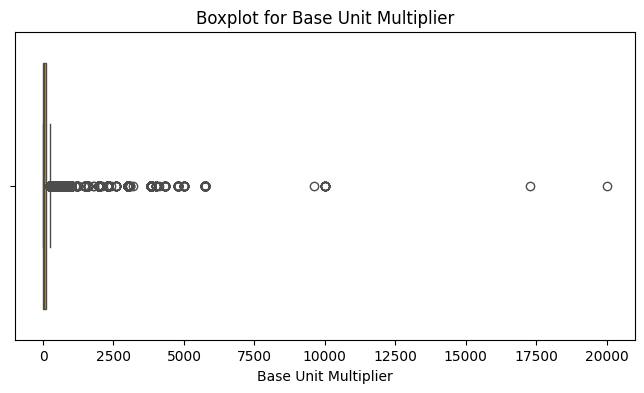

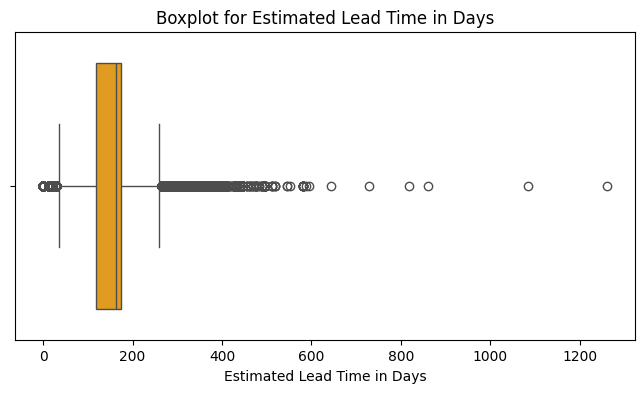

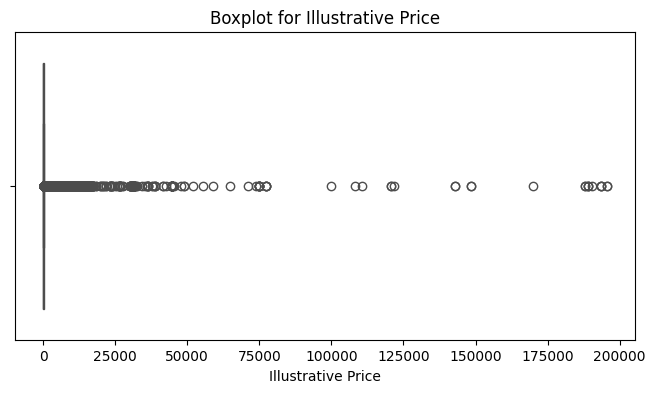

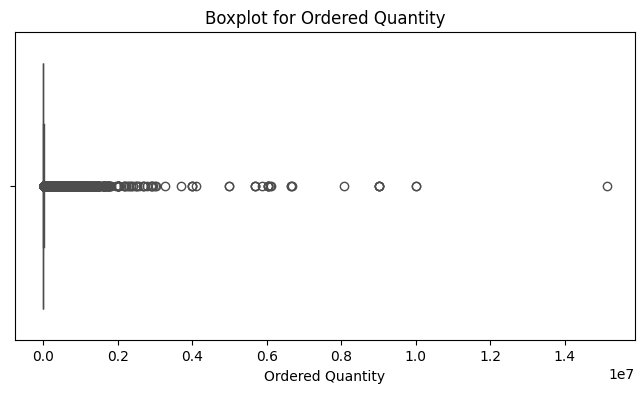

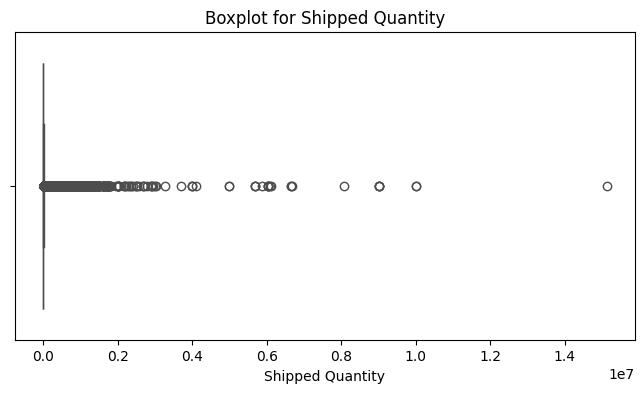

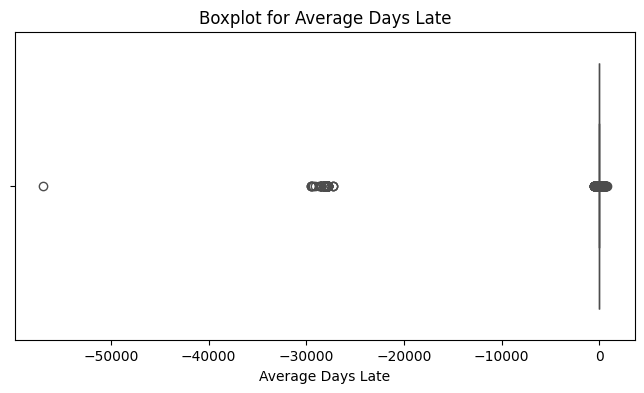

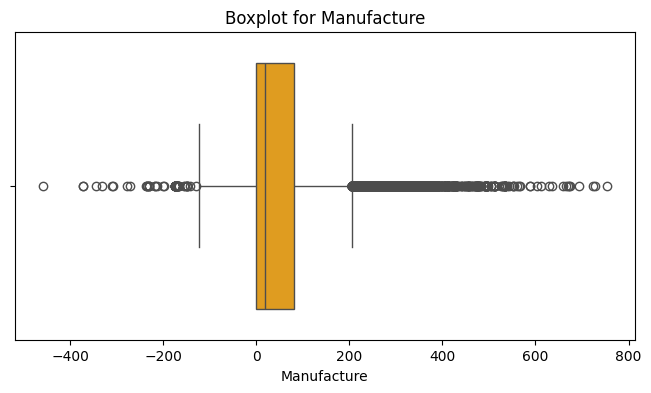

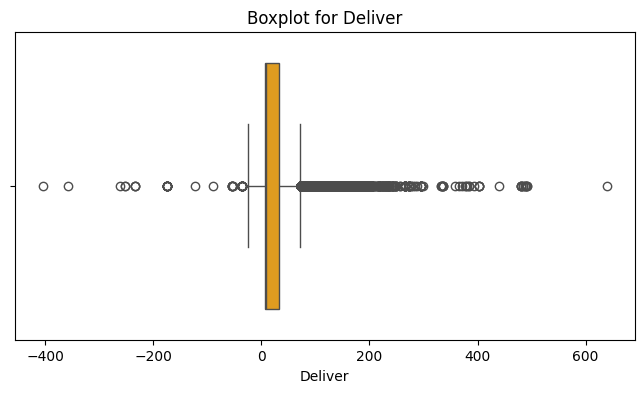

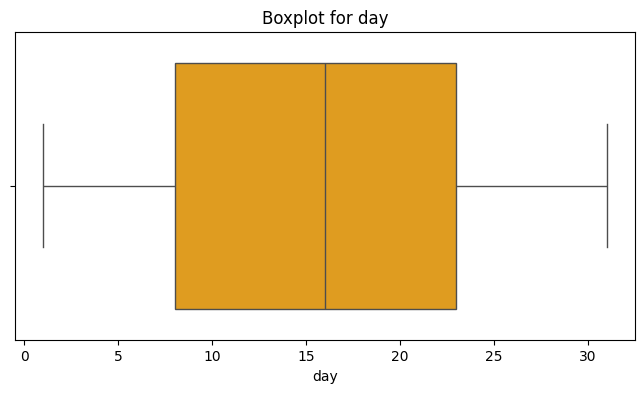

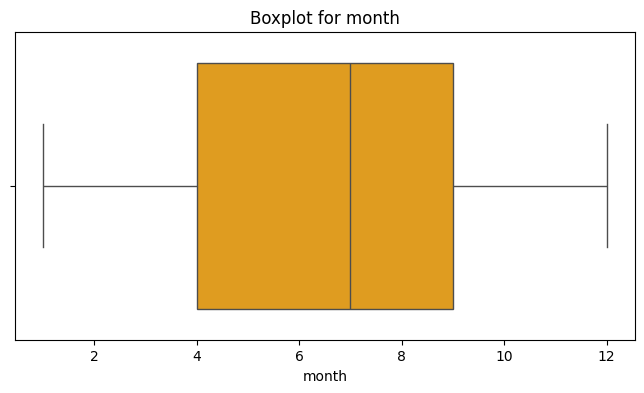

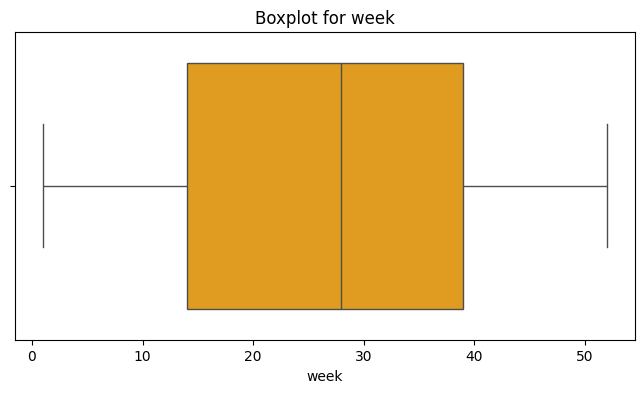

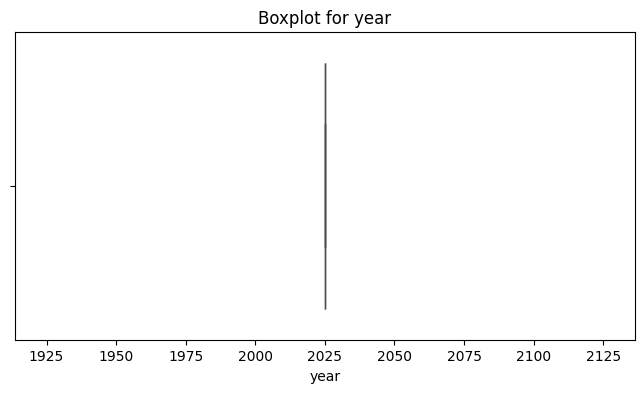

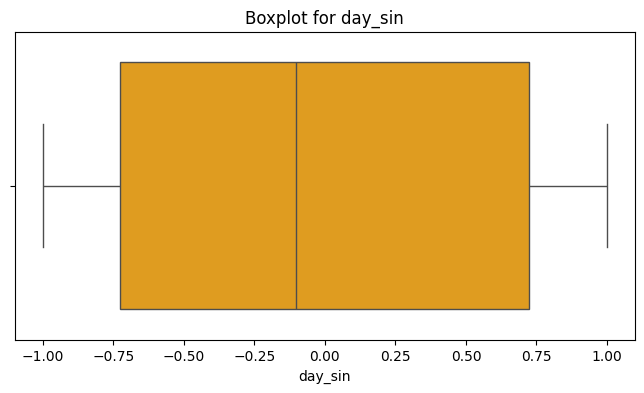

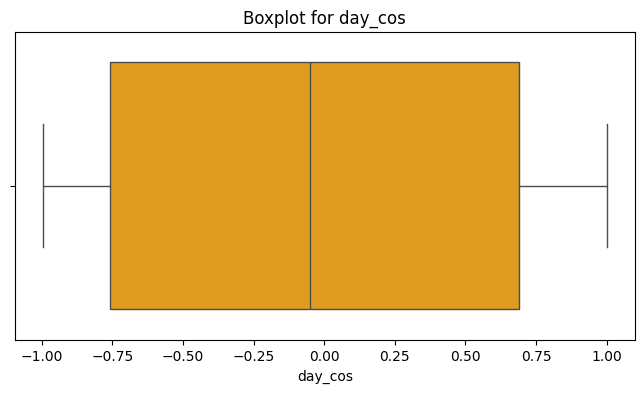

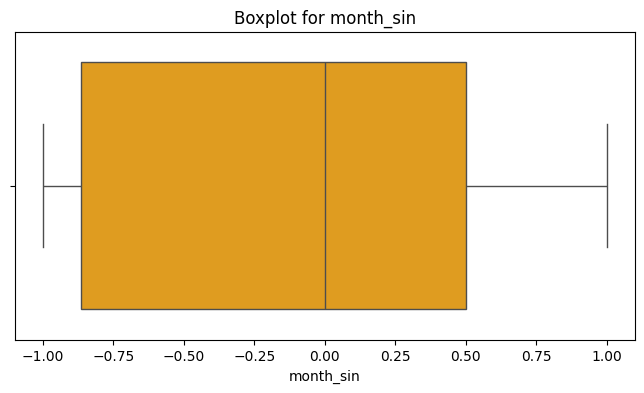

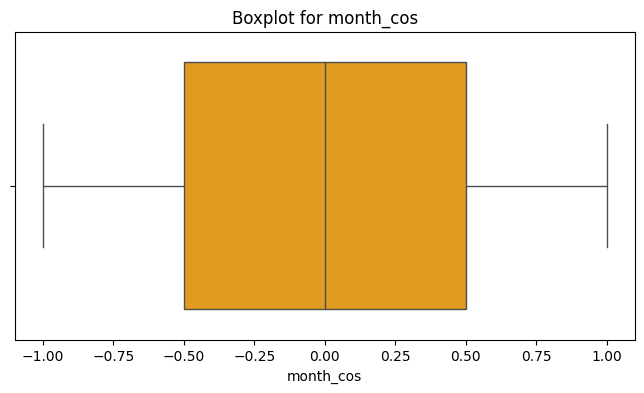

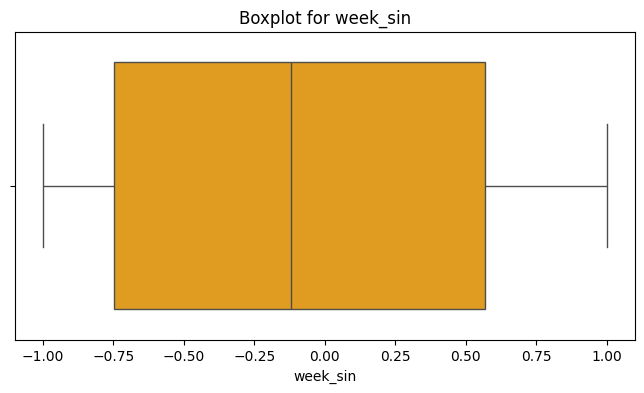

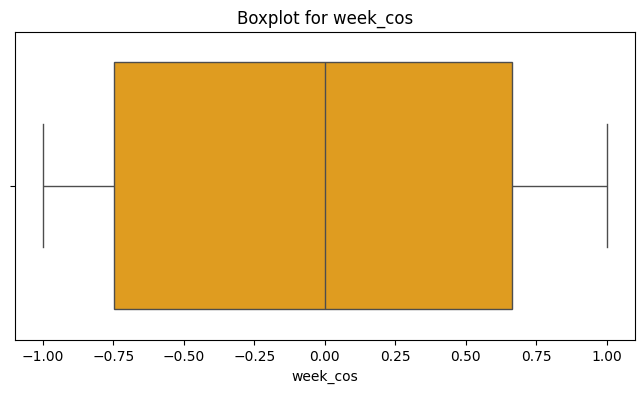

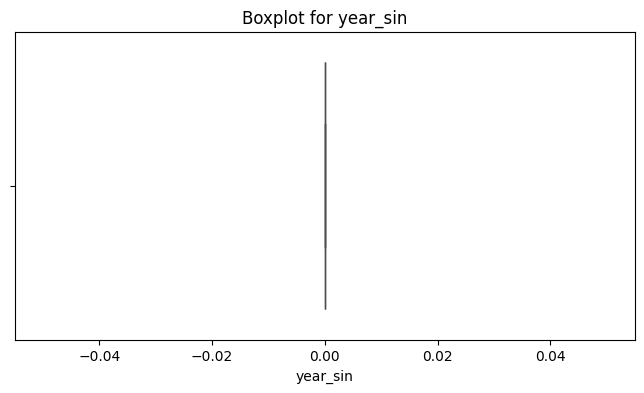

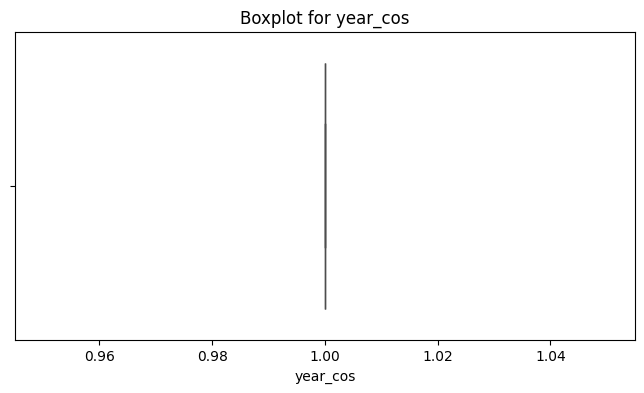

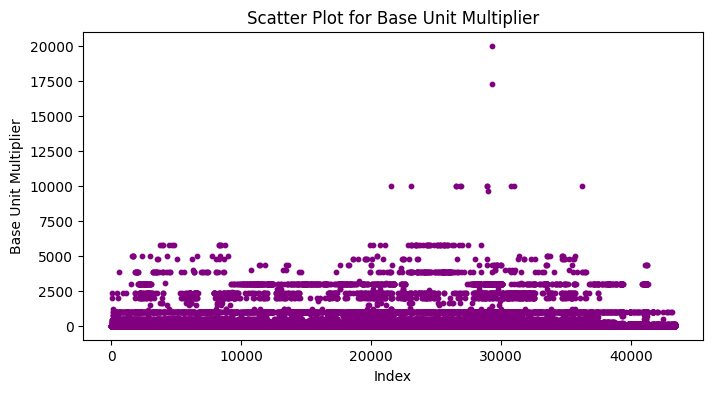

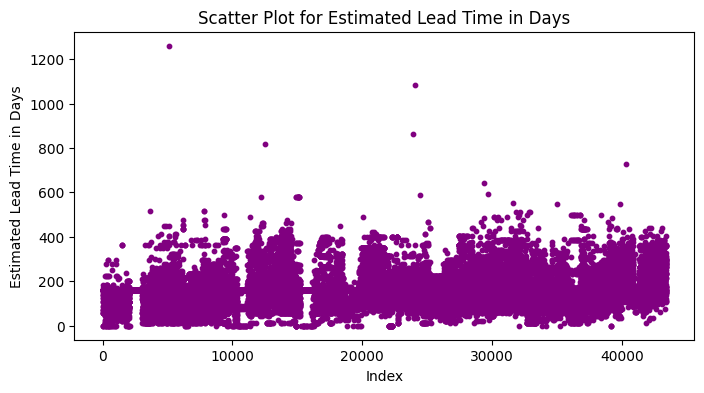

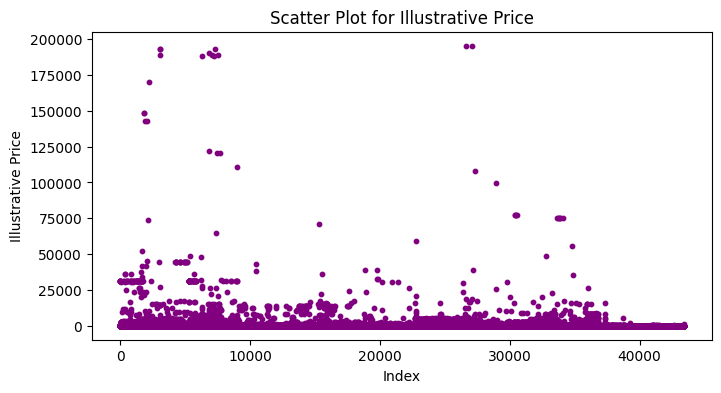

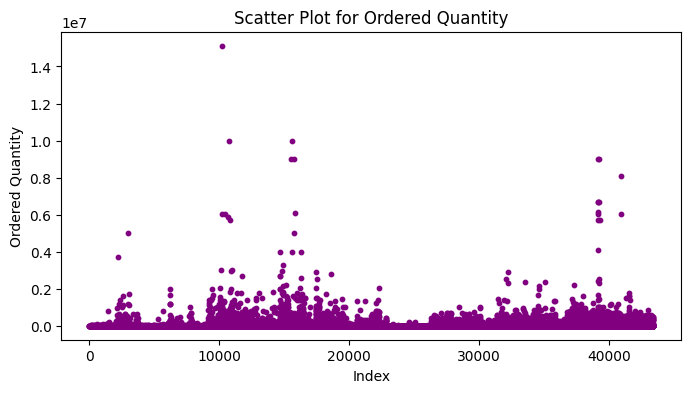

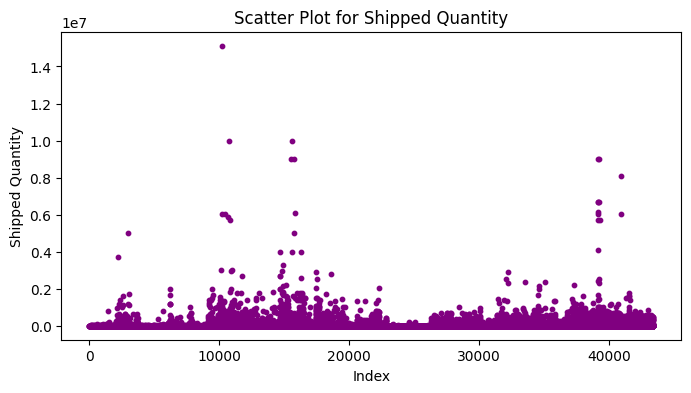

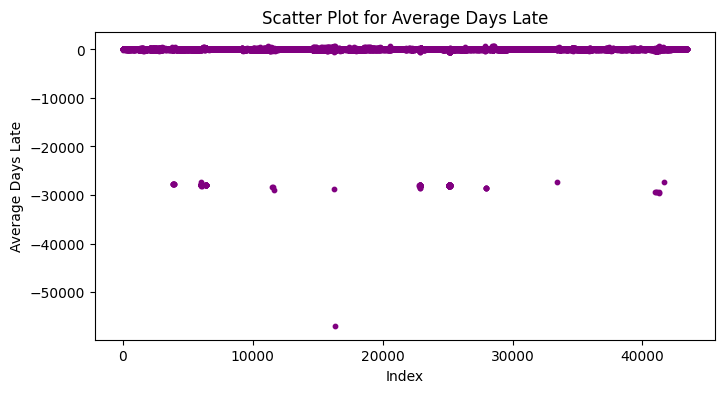

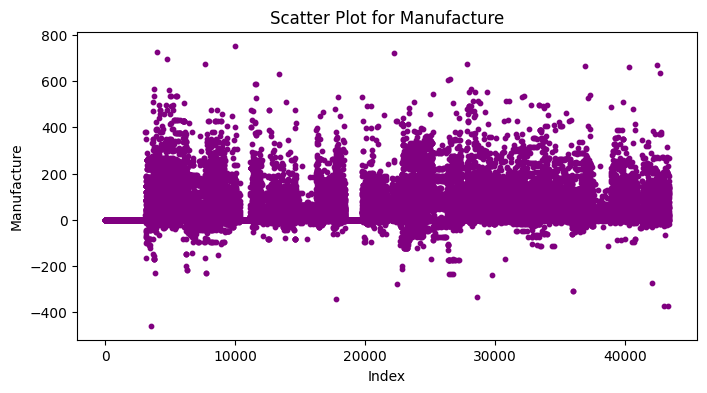

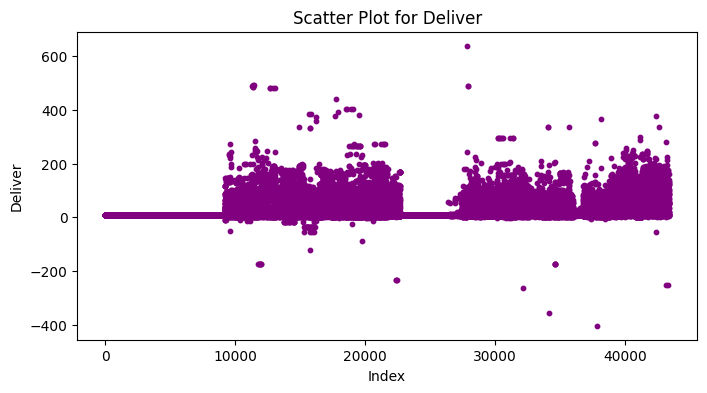

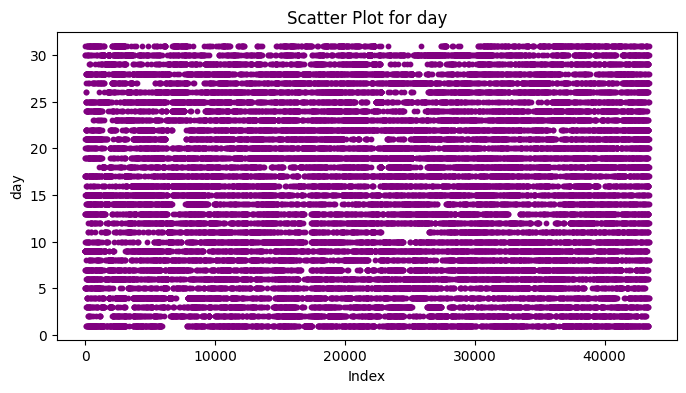

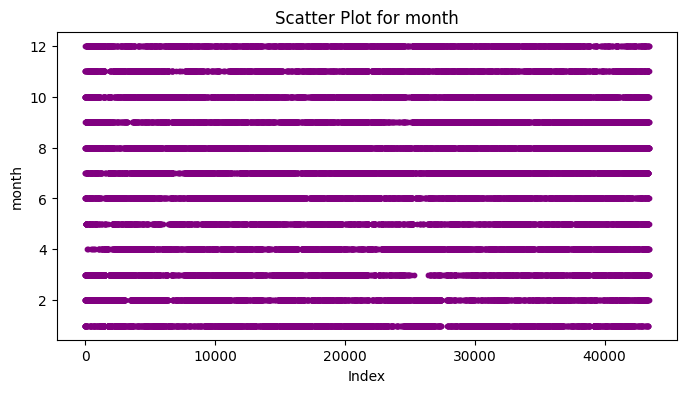

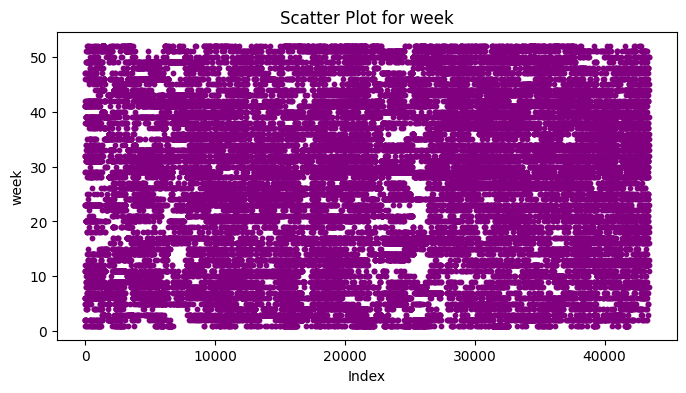

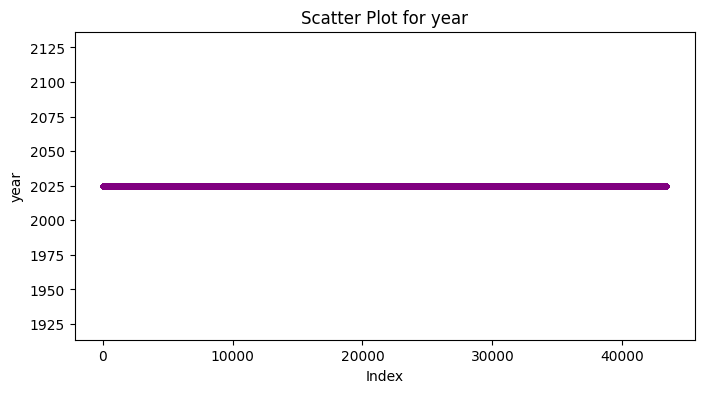

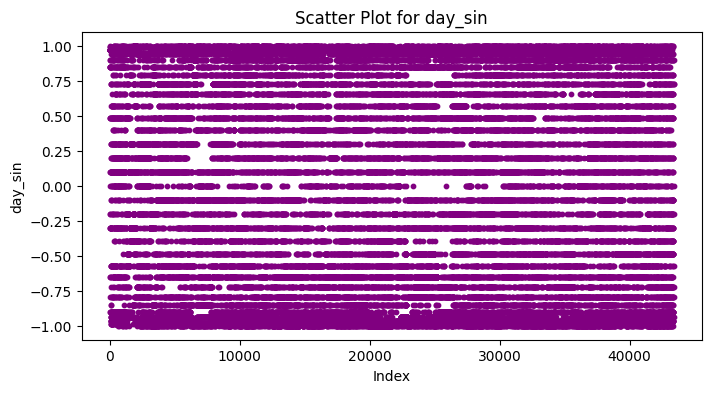

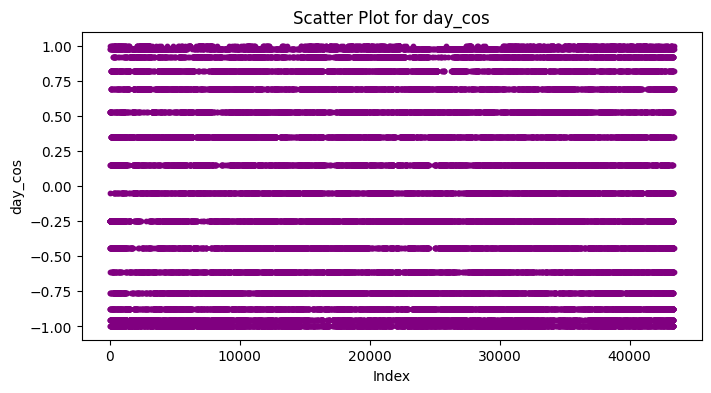

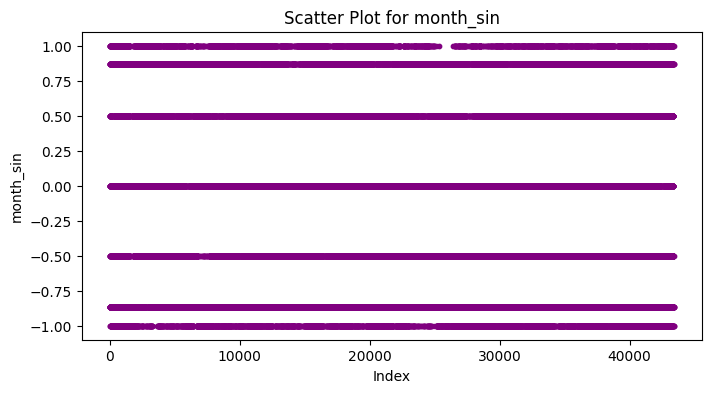

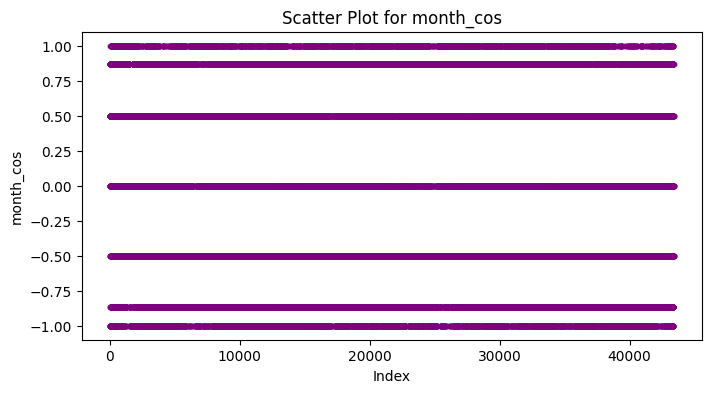

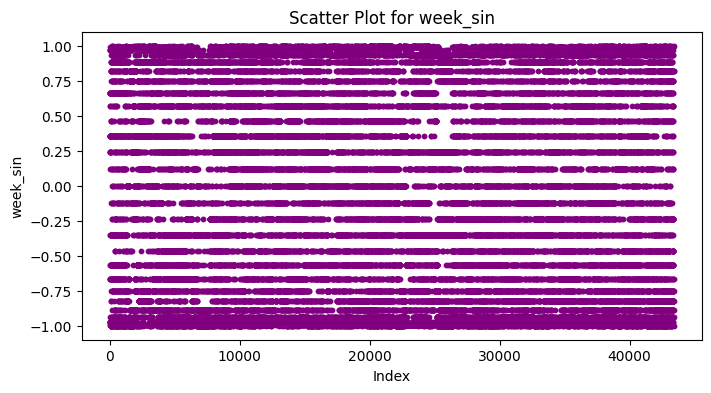

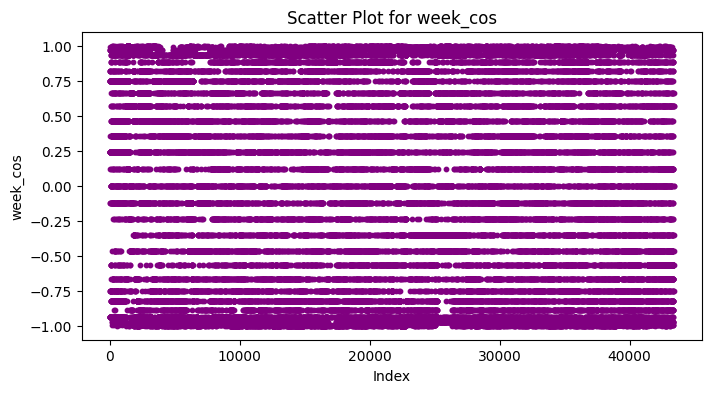

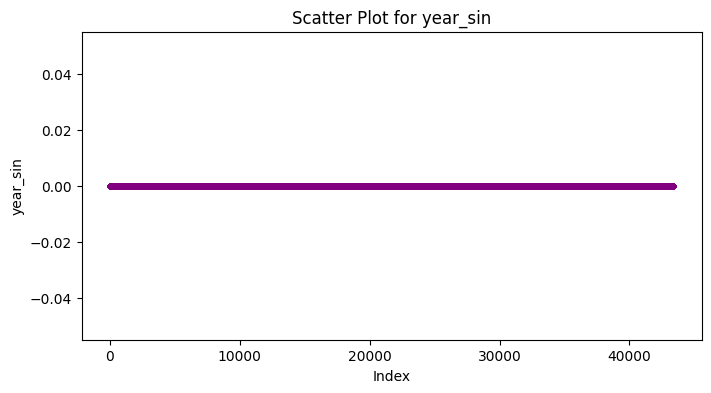

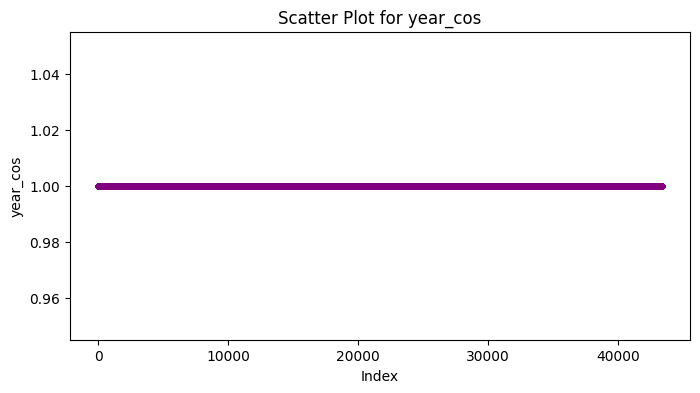

In [37]:

# Step 1: Separate Columns
year_columns = [
    'Order Entry Year', 'Revised Agreed Delivery Date Year',
    'Estimated Delivery Date Year', 'Latest Actual Delivery Date Year'
]

categorical_columns = [
    'Country', 'Product_Name', 'Product Category', 'Order Type', 'Fulfillment Method',
    'UOM', 'Base Unit', 'Item Tracer Category', 'Transportation Mode',
    'D365 Health Element', 'D365 Funding Source', 'D365 Funding Source Detail'
]

continuous_numerical_cols = [
    col for col in df_selected.select_dtypes(include=['number']).columns
    if col not in year_columns + categorical_columns
]

print("Continuous Numerical Columns:", continuous_numerical_cols)

# Step 2: Detect Outliers using IQR
for col in continuous_numerical_cols:
    Q1 = df_selected[col].quantile(0.25)
    Q3 = df_selected[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_selected[(df_selected[col] < lower_bound) | (df_selected[col] > upper_bound)]

    print(f"Column: {col}")
    print(f"Number of Outliers Detected: {outliers.shape[0]}")
    print("-" * 60)

# Step 3: Visualize Outliers

# Boxplots for each continuous numerical column
for col in continuous_numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_selected[col], color='orange')
    plt.title(f'Boxplot for {col}')
    plt.show()

# Scatterplots (against index) to check for extreme values
for col in continuous_numerical_cols:
    plt.figure(figsize=(8, 4))
    plt.scatter(df_selected.index, df_selected[col], color='purple', s=10)
    plt.title(f'Scatter Plot for {col}')
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.show()


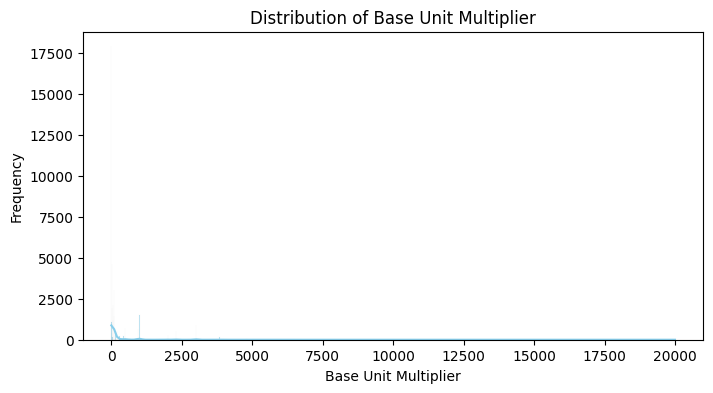

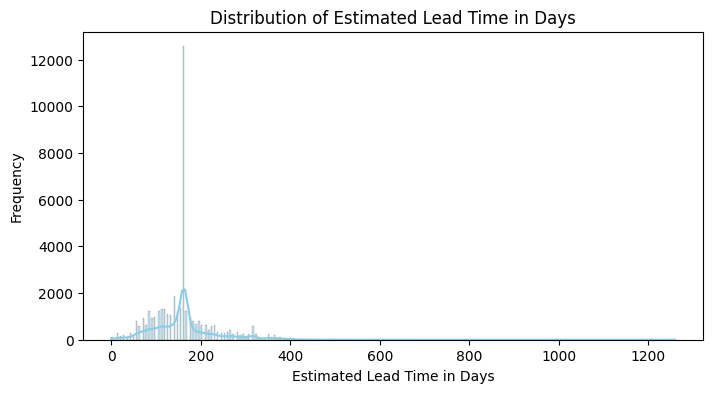

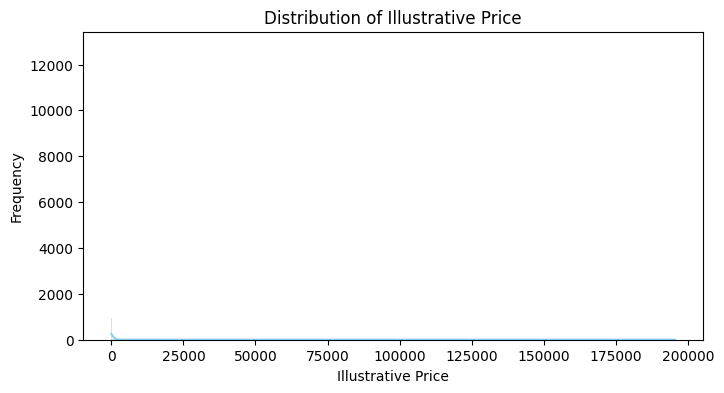

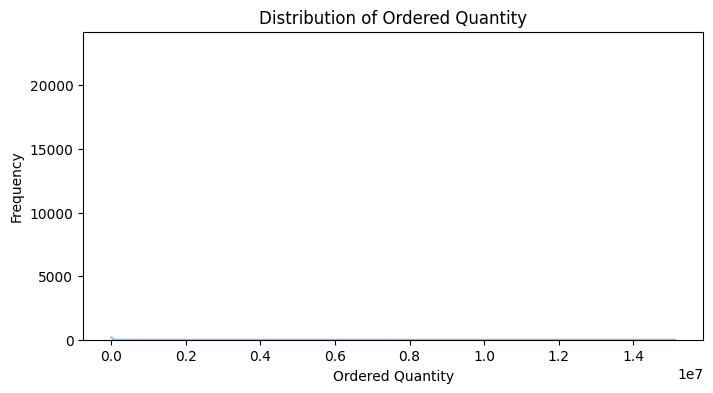

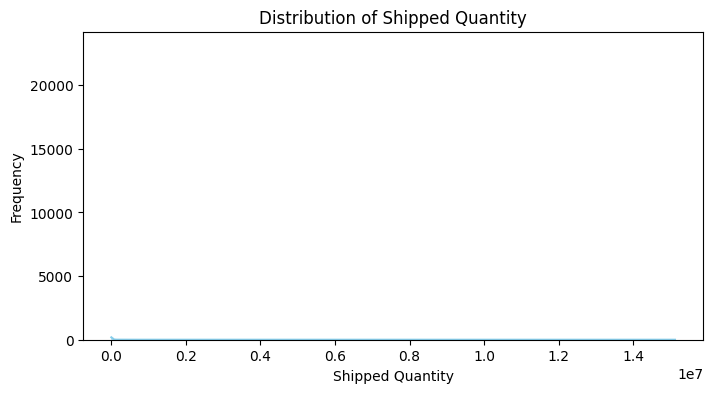

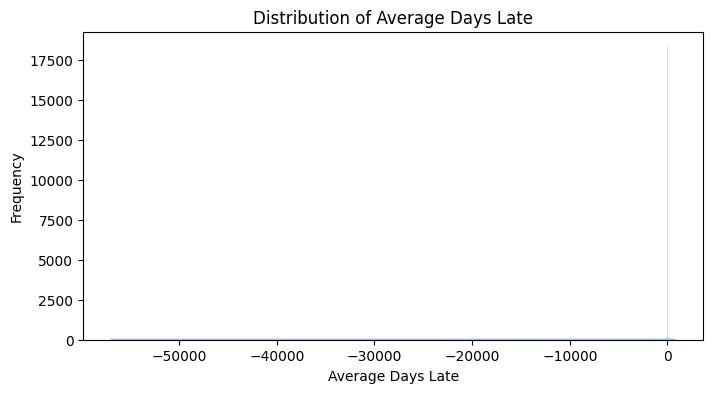

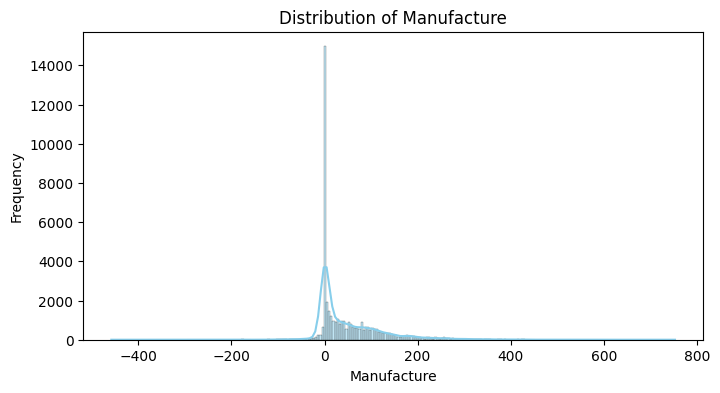

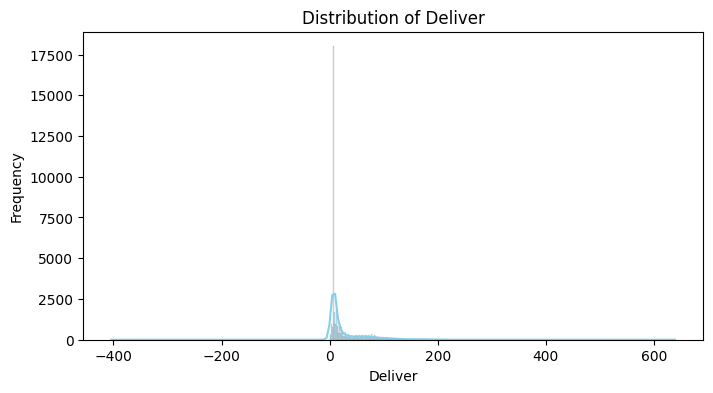

In [38]:

columns_to_check = [
    'Base Unit Multiplier', 'Estimated Lead Time in Days', 'Illustrative Price',
    'Ordered Quantity', 'Shipped Quantity', 'Average Days Late', 'Manufacture', 'Deliver'
]

for col in columns_to_check:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_selected[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


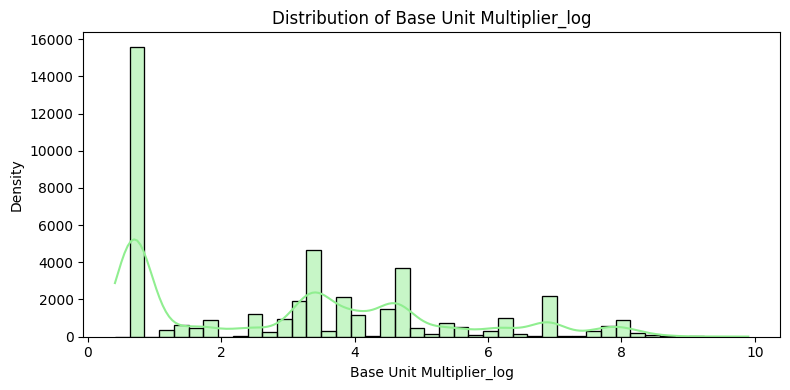

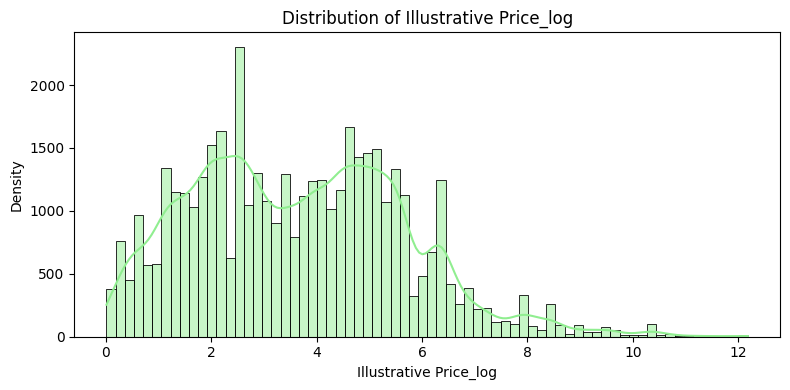

In [39]:
columns_to_log = [
    'Base Unit Multiplier',

    'Illustrative Price',

]


# Apply log1p (i.e., log(1 + x)) — handles values >= 0 safely
for col in columns_to_log:
    if (df_selected[col] <= 0).any():
        # If column has 0 or negative values, shift before log
        min_val = df_selected[col].min()
        df_selected[f'{col}_log'] = np.log1p(df_selected[col] - min_val + 1)
    else:
        # Safe to directly apply log1p
        df_selected[f'{col}_log'] = np.log1p(df_selected[col])

# List of the log-transformed columns
log_columns = [
    'Base Unit Multiplier_log',

    'Illustrative Price_log',

]

# Plot each log-transformed column
for col in log_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_selected[col].dropna(), kde=True, color='lightgreen')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

In [40]:
low_bound = df_selected['Ordered Quantity'].quantile(0.01)
high_bound = df_selected['Ordered Quantity'].quantile(0.99)

print(f"1st percentile: {low_bound}")
print(f"99th percentile: {high_bound}")




1st percentile: 1.0
99th percentile: 612500.0


In [41]:
df_trimmed = df_selected[
    (df_selected['Ordered Quantity'] >= low_bound) &
    (df_selected['Ordered Quantity'] <= high_bound)
].copy()

print(f"Original rows: {df_selected.shape[0]}")
print(f"Rows after trimming: {df_trimmed.shape[0]}")


Original rows: 43396
Rows after trimming: 42958


In [43]:
'''fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Trimmed
sns.histplot(df_trimmed['Ordered Quantity'], kde=True, ax=ax[0], color='orange')
ax[0].set_title('Trimmed Ordered Quantity Distribution')

# Log-transformed
sns.histplot(df_trimmed['Ordered Quantity_log'], kde=True, ax=ax[1], color='seagreen')
ax[1].set_title('Log-Transformed Ordered Quantity')
ax[1].set_xlabel('log(1 + Ordered Quantity)')

plt.tight_layout()
plt.show()
'''

"fig, ax = plt.subplots(1, 2, figsize=(16, 5))\n\n# Trimmed\nsns.histplot(df_trimmed['Ordered Quantity'], kde=True, ax=ax[0], color='orange')\nax[0].set_title('Trimmed Ordered Quantity Distribution')\n\n# Log-transformed\nsns.histplot(df_trimmed['Ordered Quantity_log'], kde=True, ax=ax[1], color='seagreen')\nax[1].set_title('Log-Transformed Ordered Quantity')\nax[1].set_xlabel('log(1 + Ordered Quantity)')\n\nplt.tight_layout()\nplt.show()\n"

In [44]:

columns_with_outliers = [

    'Estimated Lead Time in Days',

    'Ordered Quantity',
    'Shipped Quantity',
    'Average Days Late',
    'Manufacture',
    'Deliver'
]

# Cap outliers in-place using IQR
def cap_outliers_iqr_inplace(df_selected, columns):
    for col in columns:
        Q1 = df_selected[col].quantile(0.25)
        Q3 = df_selected[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap directly in the existing DataFrame
        df_selected[col] = df_selected[col].clip(lower=lower_bound, upper=upper_bound)

# Apply the function to df
cap_outliers_iqr_inplace(df_selected, columns_with_outliers)


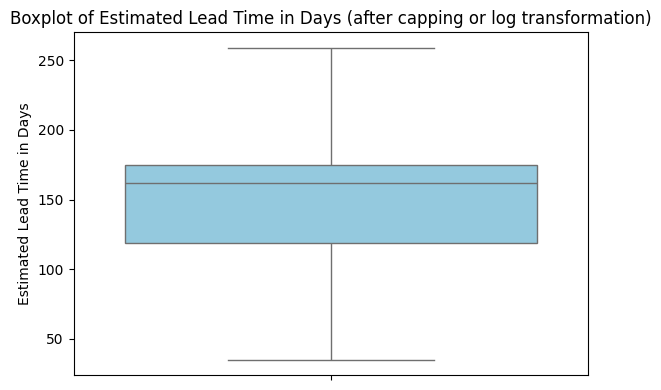

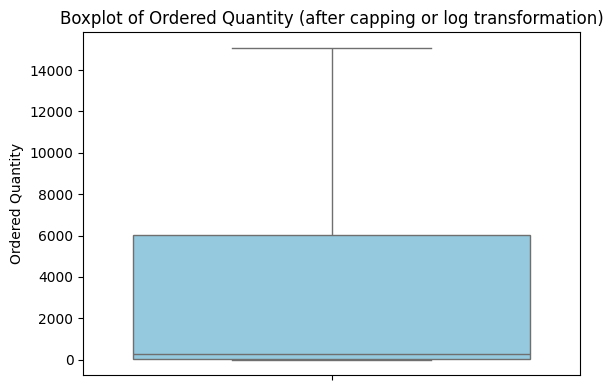

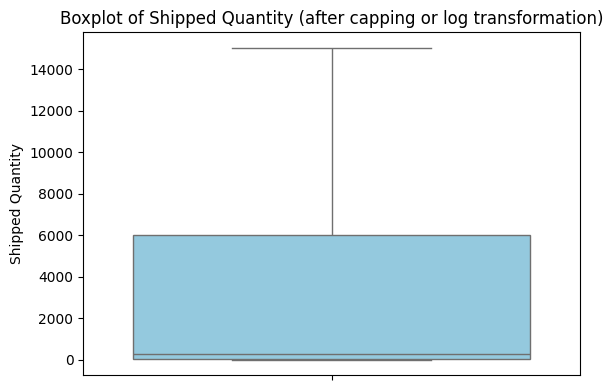

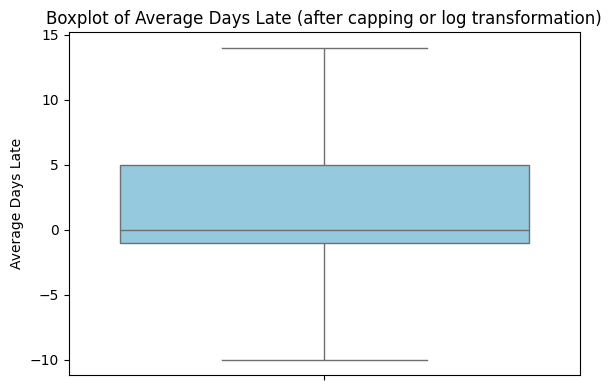

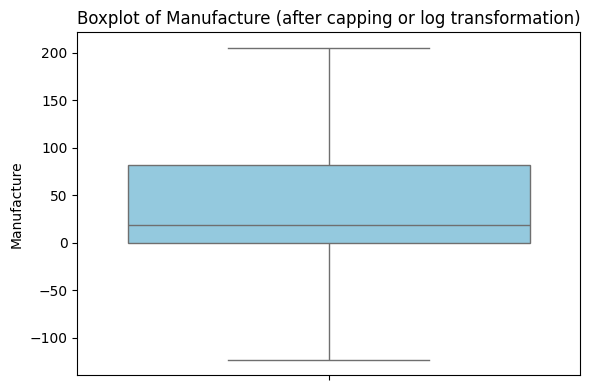

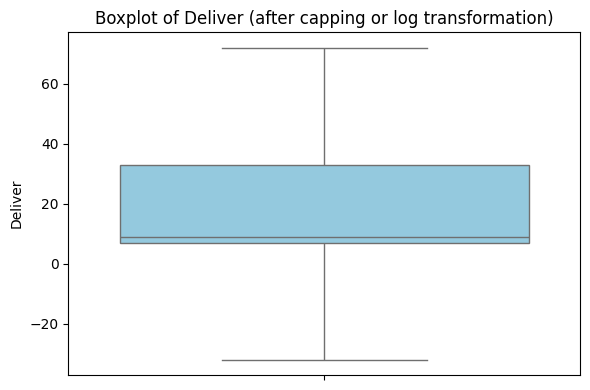

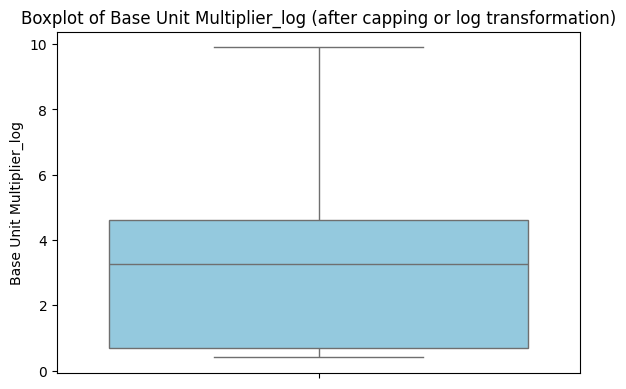

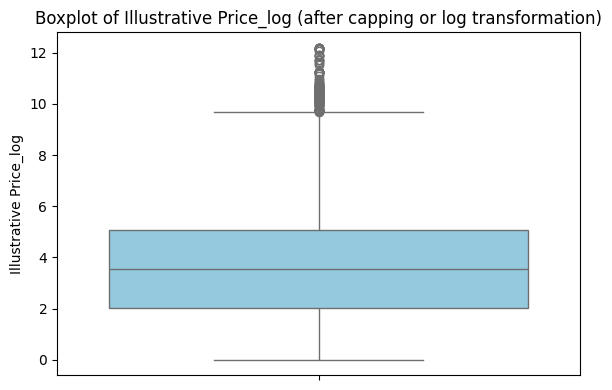

In [45]:

# Combine original capped columns and log-transformed columns
columns_with_outliers_and_logs = columns_with_outliers + [
    'Base Unit Multiplier_log',
    'Illustrative Price_log'
]

# Plot boxplots for all selected columns
import matplotlib.pyplot as plt
import seaborn as sns

for col in columns_with_outliers_and_logs:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_selected, y=col, color='skyblue')
    plt.title(f'Boxplot of {col} (after capping or log transformation)')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


In [46]:
from sklearn.preprocessing import StandardScaler

# Define the continuous features to scale
columns_to_scale = [
    'Base Unit Multiplier_log',
    'Estimated Lead Time in Days',
    'Illustrative Price_log',
    'Ordered Quantity',
    'Shipped Quantity',
    'Average Days Late',
    'Manufacture',
    'Deliver'
]

# Initialize the scaler
scaler = StandardScaler()

# Apply standardization (fit and transform)
X_scaled = scaler.fit_transform(df_selected[columns_to_scale])



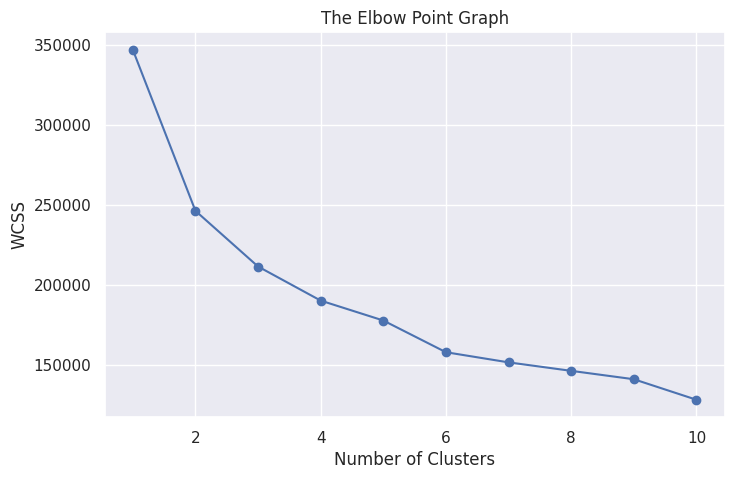

In [47]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Elbow plot
plt.figure(figsize=(8,5))
sns.set()
plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [48]:

from sklearn.decomposition import PCA
import pandas as pd

# Applying PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

# Store PCA components in a DataFrame
principalDf = pd.DataFrame(data=principalComponents,
                           columns=['principal component 1', 'principal component 2'])


In [49]:
from sklearn.cluster import KMeans

# Choose number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(principalComponents)

# Add cluster labels to PCA DataFrame
principalDf['Cluster'] = kmeans.labels_


In [50]:
# Match indices before joining
principalDf.index = df_selected.index

# Create a new DataFrame with original data + cluster labels
df_clustered = pd.concat([df_selected, principalDf['Cluster']], axis=1)


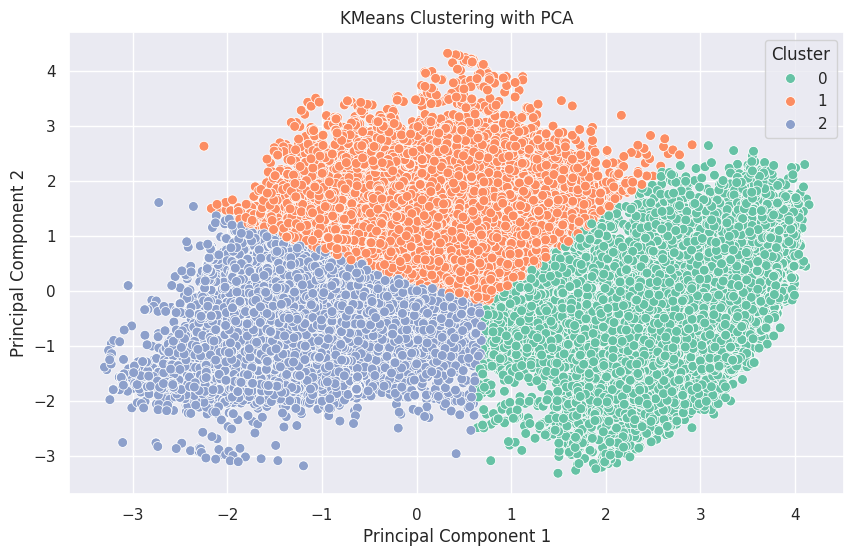

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=principalDf,
                x='principal component 1', y='principal component 2',
                hue='Cluster', palette='Set2', s=50)

plt.title('KMeans Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()
